# Pylops - Marchenko redatuming with joint datasets and missing sources

### Author: M.Ravasi

In this notebook we consider to extensions of the Marchenko inversion for joint datasets in the presence of missing sources

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import bicgstab, lsqr
from scipy.signal import convolve, fftconvolve, filtfilt, hilbert

from pylops                            import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.waveeqprocessing.marchenko import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import *

import MarchenkoFunctions as MF

In [2]:
def callback(x, xtrue, prec, psnr, mse):
    if prec is not None:
        x = prec * x
    x = x.reshape(xtrue.shape)
    psnr.append(10*np.log10(np.linalg.norm(xtrue)**2/np.linalg.norm(x - xtrue)**2))
    mse.append(np.linalg.norm(xtrue - x))

## Inputs

Input parameters 

In [3]:
path0='./datasets_new/'

toff = 0.045        # direct arrival time shift
nsmooth = 10        # time window smoothing 
nfmax = 500         # max frequency for MDC (#samples)
nfft = 2 ** 11      # number of fft samples
nstaper = 11        # source/receiver taper lenght
n_iter = 200        # iterations
    
jr = 3              # subsampling in r

Load input

Read and visualize geometry

In [4]:
# Receivers
r = np.loadtxt(path0 + 'r.dat', delimiter=',')
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = np.loadtxt(path0 + 's.dat', delimiter=',')
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points
vs = [1200, 1260]

# Geometry
nz = 401
oz = 0
dz = 4
z = np.arange(oz, oz + nz*dz, dz)

nx=751
ox=0
dx=4
x = np.arange(ox, ox + nx*dx, dx)

# Velocity
v = np.loadtxt(path0 + 'vel.dat', delimiter=',')
v2 = np.loadtxt(path0 + 'vel2.dat', delimiter=',')

# Density
rho = np.loadtxt(path0 + 'rho.dat', delimiter=',')
rho1 = np.loadtxt(path0 + 'rho2.dat', delimiter=',')

# Smooth velocity
vsm = np.loadtxt(path0 + 'vel_sm.dat', delimiter=',')

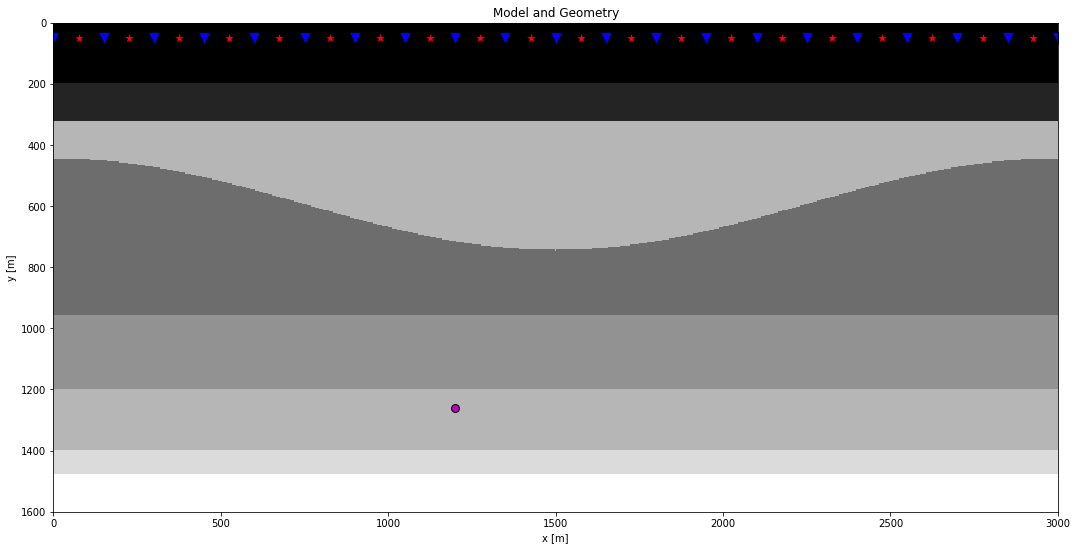

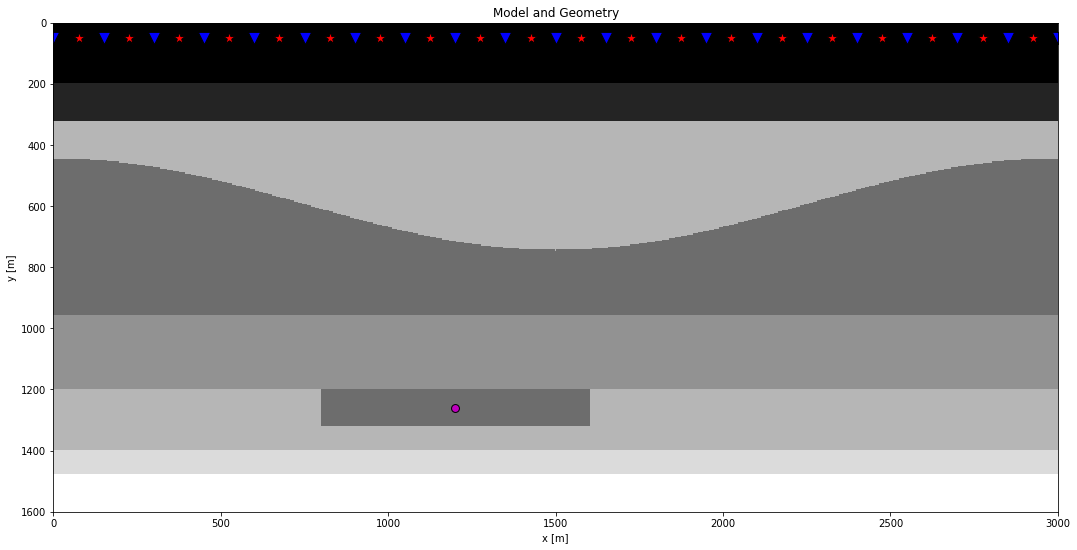

In [5]:
plt.figure(figsize=(18,9))
plt.imshow(v, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(vs[0], vs[1], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1])

plt.figure(figsize=(18,9))
plt.imshow(v2, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(vs[0], vs[1], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

Read data

In [6]:
# time axis
ot=0
nt=1081
dt=0.0025
t = np.arange(ot,ot+nt*dt,dt)
t2 = np.concatenate([-t[::-1], t[1:]])
nt2 = len(t2)

# data
R_1=np.zeros((nt, ns, nr),'f')
R_2=np.zeros((nt, ns, nr),'f')
for isrc in range(ns-1):
    is_ = isrc*jr
    R_1[:,:,isrc]=np.loadtxt(path0 + 'dat1_' + str(is_) + '.dat', delimiter=',')
    R_2[:,:,isrc]=np.loadtxt(path0 + 'dat2_' + str(is_) + '.dat', delimiter=',')

R_1 = 2 * np.swapaxes(R_1,0,2)
R_2 = 2 * np.swapaxes(R_2,0,2)

# tapering
taper = taper3d(nt, [ns, nr], [nstaper, nstaper], tapertype='hanning')
R_1 = R_1*taper
R_2 = R_2*taper

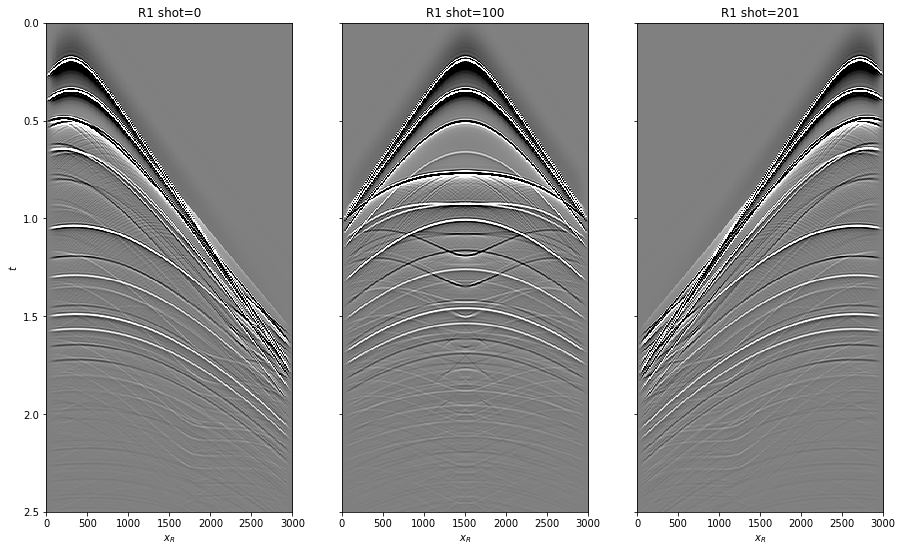

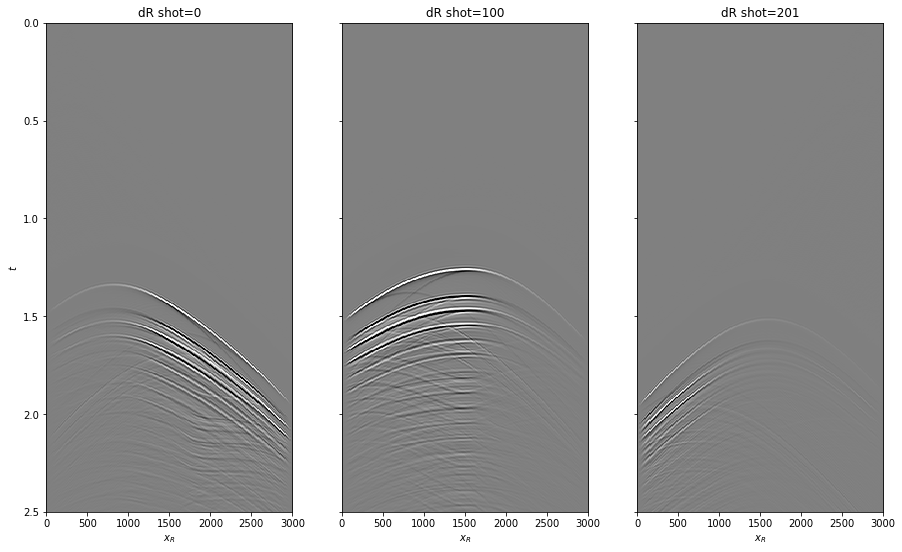

In [7]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 9))
axs[0].imshow(R_1[20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('R1 shot=0'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2.5, 0)
axs[1].imshow(R_1[ns//2].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('R1 shot=%d' %(ns//2)), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2.5, 0)
axs[2].imshow(R_1[-20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[2].set_title('R1 shot=%d' %ns), axs[2].set_xlabel(r'$x_R$')
axs[2].axis('tight');
axs[2].set_ylim(2.5, 0);

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 9))
axs[0].imshow((R_1-R_2)[20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('dR shot=0'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2.5, 0)
axs[1].imshow((R_1-R_2)[ns//2].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('dR shot=%d' %(ns//2)), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2.5, 0)
axs[2].imshow((R_1-R_2)[-20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[2].set_title('dR shot=%d' %ns), axs[2].set_xlabel(r'$x_R$')
axs[2].axis('tight');
axs[2].set_ylim(2.5, 0);

Read wavelet and traveltime 

In [8]:
wav = np.loadtxt(path0 + 'wav.dat', delimiter=',')
wav_c = np.argmax(wav)
  
trav_eik = np.loadtxt(path0 + 'trav.dat', delimiter=',')
trav_eik = np.reshape(trav_eik,(nz, ns, nx))

## Marchenko preparation

Read subsurface fields

In [9]:
G0VS = np.loadtxt(path0 + 'dat_vs0_x%d_z%d.dat' % (vs[0], vs[1]), delimiter=',')[:, ::jr]
GVS = np.loadtxt(path0 + 'dat_vs_x%d_z%d.dat' % (vs[0], vs[1]), delimiter=',')[:, ::jr]

# convolve with wavelet
G0VS = np.apply_along_axis(convolve, 0, G0VS, wav, mode='full')
G0VS = G0VS[wav_c:][:nt]
GVS = np.apply_along_axis(convolve, 0, GVS, wav, mode='full') 
GVS = GVS[wav_c:][:nt]

In [10]:
G0VS1 = np.loadtxt(path0 + 'dat2_vs0_x%d_z%d.dat' % (vs[0], vs[1]), delimiter=',')[:, ::jr]
GVS1 = np.loadtxt(path0 + 'dat2_vs_x%d_z%d.dat' % (vs[0], vs[1]), delimiter=',')[:, ::jr]

# convolve with wavelet
G0VS1 = np.apply_along_axis(convolve, 0, G0VS1, wav, mode='full')
G0VS1 = G0VS1[wav_c:][:nt]
GVS1 = np.apply_along_axis(convolve, 0, GVS1, wav, mode='full') 
GVS1 = GVS1[wav_c:][:nt]

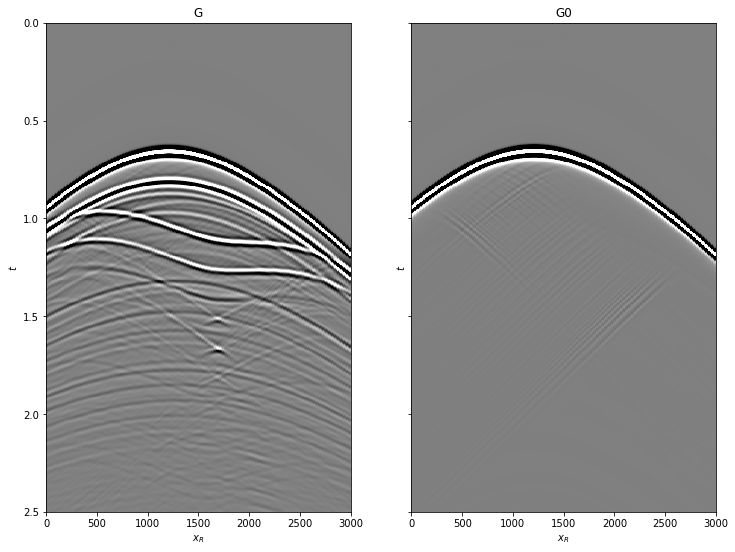

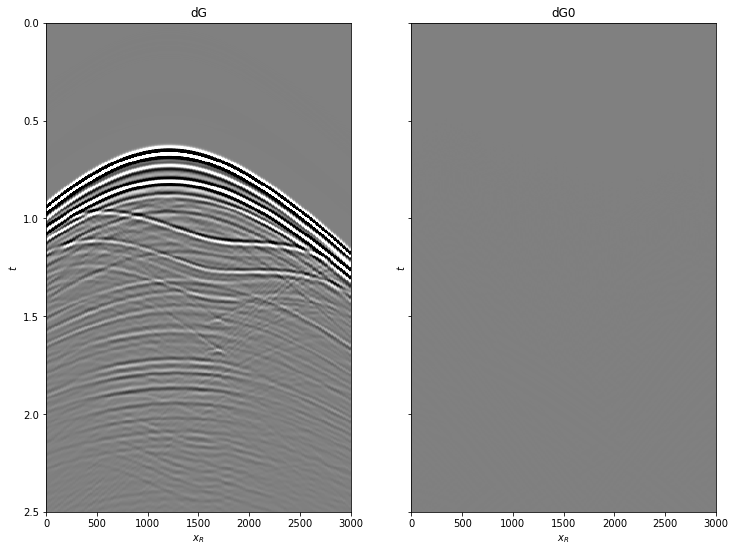

In [11]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 9))
axs[0].imshow(GVS, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('G'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2.5, 0)
axs[1].imshow(G0VS, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('G0'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
axs[1].set_ylim(2.5, 0);

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 9))
axs[0].imshow(GVS1 - GVS, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('dG'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2.5, 0)
axs[1].imshow(G0VS1 - G0VS, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('dG0'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
axs[1].set_ylim(2.5, 0);

Create first arrival

In [12]:
# direct arrival window - traveltime
directVS = trav_eik[MF.find_closest(vs[1],z)-1, :, MF.find_closest(vs[0],x)-1]
directVS_off = directVS - toff

G0sub = directwave(wav, directVS, nt, dt, nfft=2**11)

Create window

In [13]:
# window
idirectVS_off = np.round(directVS_off/dt).astype(np.int)
w = np.zeros((nr, nt))
for ir in range(nr):
    w[ir, :idirectVS_off[ir]]=1            
w = np.hstack((np.fliplr(w), w[:, 1:]))

if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    w  = filtfilt(smooth, 1, w)

Create analytical direct wave

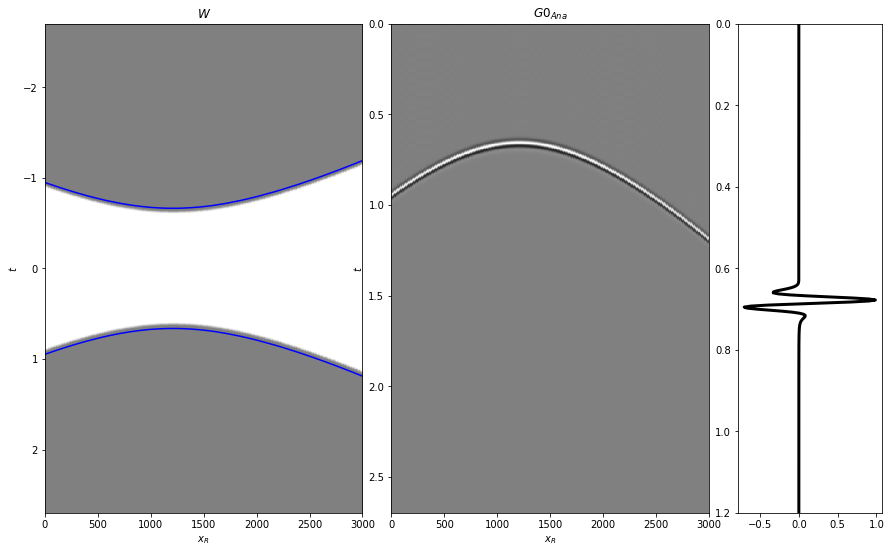

In [14]:
fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(w.T, cmap='gray', vmin=-1, vmax=1, 
           extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax1.plot(r[0], directVS,'b'),ax1.plot(r[0], -directVS,'b')
ax1.set_title(r'$W$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax2.imshow(G0sub/G0sub.max(), cmap='gray', vmin=-1, vmax=1, 
           extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax2.set_title(r'$G0_{Ana}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')

ax3.plot(G0sub[:, nr//2]/G0sub.max(), t, 'k', lw=3)
ax3.set_ylim(1.2, 0);

## Indipendent Marchenko with full sources

Let's start by creating benchmark responses

In [15]:
Rtwosided_1 = np.concatenate((np.zeros((nr, ns, nt-1)), R_1), axis=-1)
R1twosided_1 = np.concatenate((np.flip(R_1, axis=-1), np.zeros((nr, ns, nt-1))), axis=-1)
Rtwosided_fft_1 = np.fft.rfft(Rtwosided_1, 2*nt-1, axis=-1)/np.sqrt(2*nt-1)
Rtwosided_fft_1 = Rtwosided_fft_1[...,:nfmax]
R1twosided_fft_1 = np.fft.rfft(R1twosided_1, 2*nt-1, axis=-1)/np.sqrt(2*nt-1)
R1twosided_fft_1 = R1twosided_fft_1[...,:nfmax]

Rtwosided_2 = np.concatenate((np.zeros((nr, ns, nt-1)), R_2), axis=-1)
R1twosided_2 = np.concatenate((np.flip(R_2, axis=-1), np.zeros((nr, ns, nt-1))), axis=-1)
Rtwosided_fft_2 = np.fft.rfft(Rtwosided_2, 2*nt-1, axis=-1)/np.sqrt(2*nt-1)
Rtwosided_fft_2 = Rtwosided_fft_2[...,:nfmax]
R1twosided_fft_2 = np.fft.rfft(R1twosided_2, 2*nt-1, axis=-1)/np.sqrt(2*nt-1)
R1twosided_fft_2 = R1twosided_fft_2[...,:nfmax]

In [16]:
# Operators
Rop1 = MDC(Rtwosided_fft_1, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, dtype='complex64')
R1op1 = MDC(R1twosided_fft_1, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, dtype='complex64')

Rop2 = MDC(Rtwosided_fft_2, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, dtype='complex64')
R1op2 = MDC(R1twosided_fft_2, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, dtype='complex64')
Wsop = Diagonal(w.flatten())
Wrop = Diagonal(w.flatten())
Iop = Identity(nr*(2*nt-1))

# Input focusing function
fd_plus =  np.concatenate((np.fliplr(G0sub.T), np.zeros((nr, nt-1))), axis=-1)
    
# Operators   
Mop1 = VStack([HStack([Iop, -1*Wsop*Rop1]),
               HStack([-1*Wsop*R1op1, Iop])])*BlockDiag([Wrop, Wrop])
Mop2 = VStack([HStack([Iop, -1*Wsop*Rop2]),
               HStack([-1*Wsop*R1op2, Iop])])*BlockDiag([Wrop, Wrop])

Gop1 = VStack([HStack([Iop, -1*Rop1]),
               HStack([-1*R1op1, Iop])])
Gop2 = VStack([HStack([Iop, -1*Rop2]),
               HStack([-1*R1op2, Iop])])

dottest(Gop1, 2*ns*(2*nt-1), 2*nr*(2*nt-1), verb=True)
dottest(Mop1, 2*ns*(2*nt-1), 2*nr*(2*nt-1), verb=True);

Dot test passed, v^T(Opu)=1168.287448 - u^T(Op^Tv)=1168.287448
Dot test passed, v^T(Opu)=603.979856 - u^T(Op^Tv)=603.979856


In [17]:
# RTM
p0_1_minus_l2indip = Rop1 * fd_plus.flatten()
p0_1_minus_l2indip = p0_1_minus_l2indip.reshape(ns, (2*nt-1))

p0_2_minus_l2indip = Rop2 * fd_plus.flatten()
p0_2_minus_l2indip = p0_2_minus_l2indip.reshape(ns, (2*nt-1))

# Data
d1 = Wsop*Rop1*fd_plus.flatten()
d1 = np.concatenate((d1.reshape(ns, 2*nt-1), np.zeros((ns, 2*nt-1))))
d2 = Wsop*Rop2*fd_plus.flatten()
d2 = np.concatenate((d2.reshape(ns, 2*nt-1), np.zeros((ns, 2*nt-1))))

# Inverse
f1_1_l2indip = lsqr(Mop1, d1.flatten(), iter_lim=20, show=True)[0]
f1_1_l2indip = f1_1_l2indip.reshape(2*nr, nt2)

f1_2_l2indip = lsqr(Mop2, d2.flatten(), iter_lim=20, show=True)[0]
f1_2_l2indip = f1_2_l2indip.reshape(2*nr, nt2)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has   868722 rows  and   868722 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   5.242e+01  5.242e+01    1.0e+00  2.0e-02
     1  0.00000e+00   2.320e+01  2.320e+01    4.4e-01  9.8e-01   1.2e+00  1.0e+00
     2  0.00000e+00   1.335e+01  1.335e+01    2.5e-01  4.0e-01   1.9e+00  2.2e+00
     3  0.00000e+00   1.051e+01  1.051e+01    2.0e-01  2.8e-01   2.3e+00  3.4e+00
     4  0.00000e+00   8.224e+00  8.224e+00    1.6e-01  2.7e-01   2.7e+00  5.1e+00
     5  0.00000e+00   6.545e+00  6.545e+00    1.2e-01  2.0e-01   3.0e+00  6.9e+00
     6  0.00000e+00   5.554e+00  5.554e+00    1.1e-01  1.7e-01   3.3e+00  8.7e+00
     7  0.00000e+00   4.643e+00  4.643e+00    8.9e-02  1.7e-01   3.6e+00  1.1e+01
     8  0.00000e+00   3.904e

In [18]:
f1_1_tot_l2indip = f1_1_l2indip + np.concatenate((np.zeros((nr, 2*nt-1)), fd_plus))
f1_2_tot_l2indip = f1_2_l2indip + np.concatenate((np.zeros((nr, 2*nt-1)), fd_plus))

g_1_tot_l2indip = Gop1*f1_1_tot_l2indip.flatten()
g_1_tot_l2indip = g_1_tot_l2indip.reshape(2*ns, (2*nt-1))
g_2_tot_l2indip = Gop2*f1_2_tot_l2indip.flatten()
g_2_tot_l2indip = g_2_tot_l2indip.reshape(2*ns, (2*nt-1))

f1_1_minus_l2indip, f1_1_plus_l2indip =  f1_1_tot_l2indip[:nr], f1_1_tot_l2indip[nr:]
f1_2_minus_l2indip, f1_2_plus_l2indip =  f1_2_tot_l2indip[:nr], f1_2_tot_l2indip[nr:]
g_1_minus_l2indip, g_1_plus_l2indip =  -g_1_tot_l2indip[:ns], np.fliplr(g_1_tot_l2indip[ns:])
g_2_minus_l2indip, g_2_plus_l2indip =  -g_2_tot_l2indip[:ns], np.fliplr(g_2_tot_l2indip[ns:])

g_1_tot_l2indip = g_1_minus_l2indip + g_1_plus_l2indip
g_2_tot_l2indip = g_2_minus_l2indip + g_2_plus_l2indip

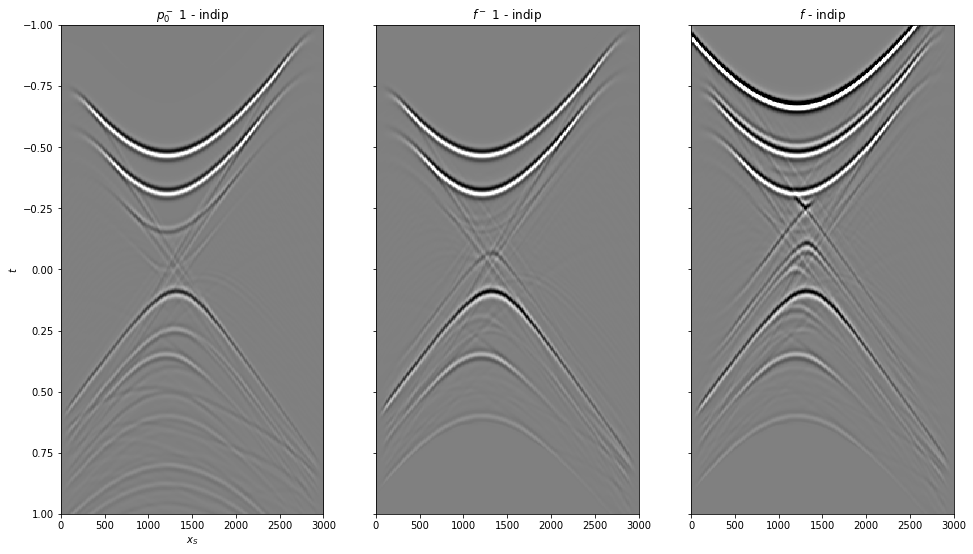

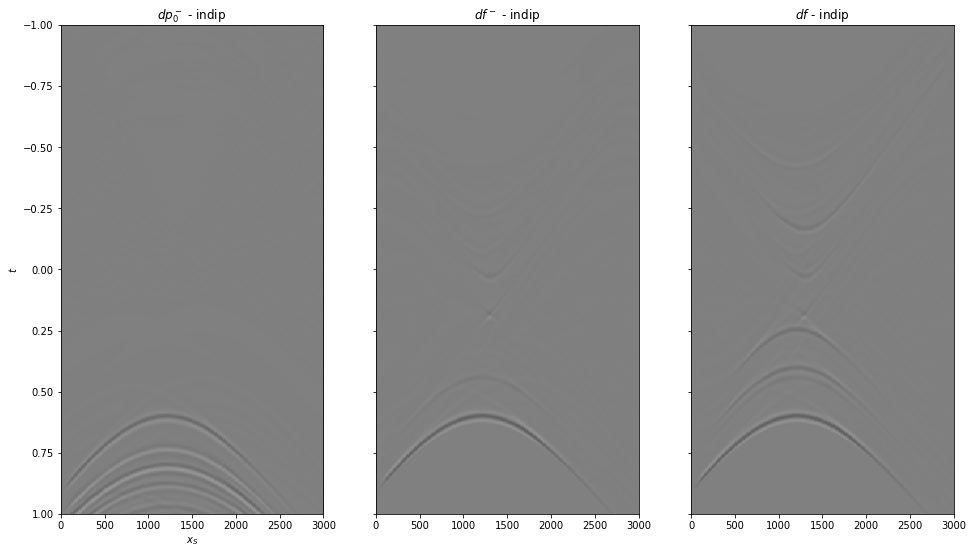

In [19]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_1_minus_l2indip.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$ 1 - indip'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_1_minus_l2indip.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$ 1 - indip'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_1_minus_l2indip.T + f1_1_plus_l2indip.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f$ - indip'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_2_minus_l2indip.T-p0_1_minus_l2indip.T, cmap='gray', 
              vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$dp_0^-$ - indip'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_2_minus_l2indip.T - f1_1_minus_l2indip.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$df^-$ - indip'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow((f1_2_minus_l2indip.T + f1_2_plus_l2indip.T) - (f1_1_minus_l2indip.T + f1_1_plus_l2indip.T), 
              cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$df$ - indip'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);


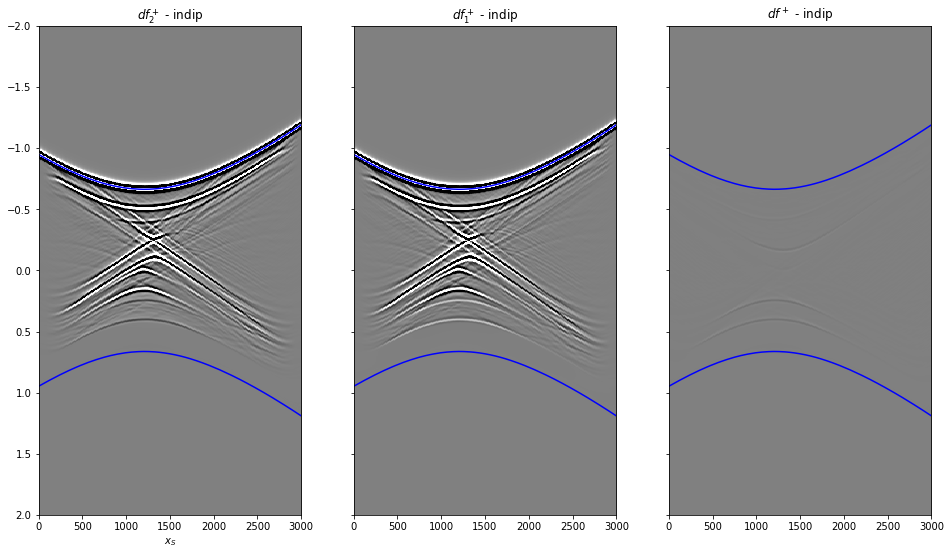

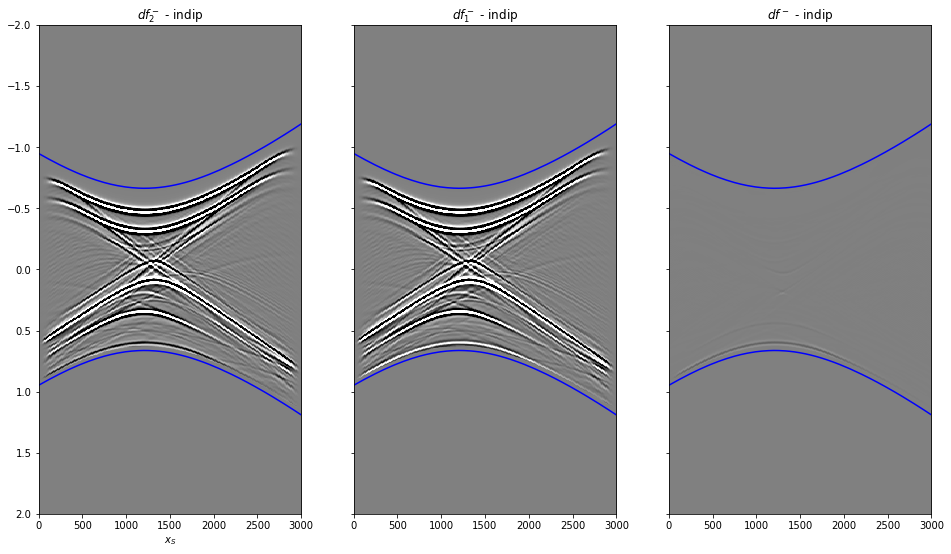

In [20]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(f1_2_plus_l2indip.T, cmap='gray', 
              vmin=-1e-1, vmax=1e-1, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].plot(r[0], directVS,'b'),axs[0].plot(r[0], -directVS,'b')
axs[0].set_title(r'$df^+_2$ - indip'), axs[0].set_xlabel(r'$x_S$')
axs[0].axis('tight')
axs[0].set_ylim(2, -2)
axs[1].imshow(f1_1_plus_l2indip.T, cmap='gray', vmin=-1e-1, vmax=1e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].plot(r[0], directVS,'b'),axs[1].plot(r[0], -directVS,'b')
axs[1].set_title(r'$df^+_1$ - indip'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(2, -2)
axs[2].imshow(f1_2_plus_l2indip.T - f1_1_plus_l2indip.T, 
              cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].plot(r[0], directVS,'b'),axs[2].plot(r[0], -directVS,'b')
axs[2].set_title(r'$df^+$ - indip'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(2, -2);

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(f1_2_minus_l2indip.T, cmap='gray', 
              vmin=-1e-1, vmax=1e-1, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].plot(r[0], directVS,'b'),axs[0].plot(r[0], -directVS,'b')
axs[0].set_title(r'$df^-_2$ - indip'), axs[0].set_xlabel(r'$x_S$')
axs[0].axis('tight')
axs[0].set_ylim(2, -2)
axs[1].imshow(f1_1_minus_l2indip.T, cmap='gray', vmin=-1e-1, vmax=1e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].plot(r[0], directVS,'b'),axs[1].plot(r[0], -directVS,'b')
axs[1].set_title(r'$df^-_1$ - indip'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(2, -2)
axs[2].imshow(f1_2_minus_l2indip.T - f1_1_minus_l2indip.T, 
              cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].plot(r[0], directVS,'b'),axs[2].plot(r[0], -directVS,'b')
axs[2].set_title(r'$df^-$ - indip'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(2, -2);

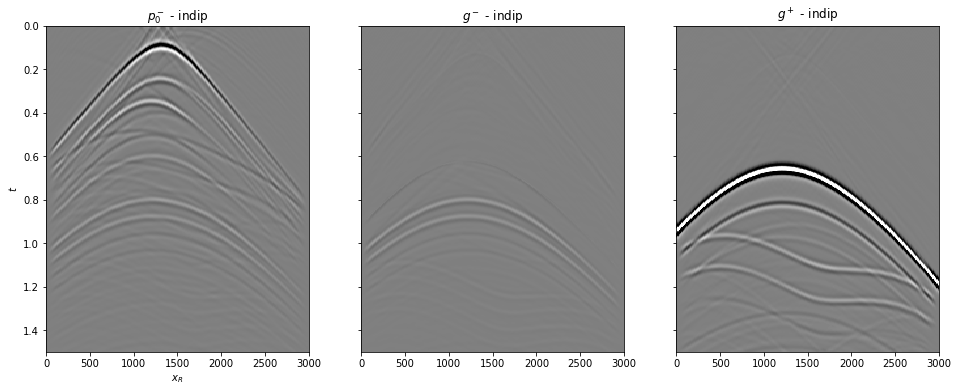

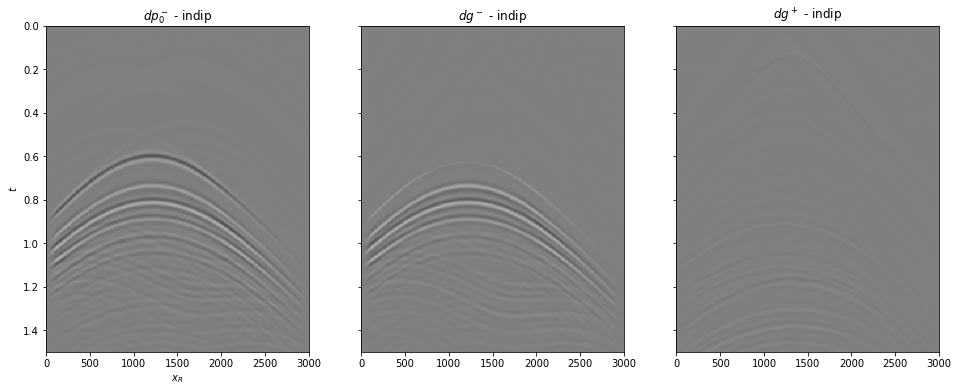

In [21]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 6))
axs[0].imshow(p0_1_minus_l2indip.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$ - indip'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0);
axs[1].imshow(g_1_minus_l2indip.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$ - indip'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0);
axs[2].imshow(g_1_plus_l2indip.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$ - indip'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1.5, 0);

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 6))
axs[0].imshow(p0_2_minus_l2indip.T - p0_1_minus_l2indip.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$dp_0^-$ - indip'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0);
axs[1].imshow(g_2_minus_l2indip.T - g_1_minus_l2indip.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$dg^-$ - indip'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0);
axs[2].imshow(g_2_plus_l2indip.T - g_1_plus_l2indip.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$dg^+$ - indip'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1.5, 0);


## Joint Marchenko with full sources

In [22]:
SumOp = VStack([HStack([Identity(2*(2*nt-1)*nr), Identity(2*(2*nt-1)*nr), Zero(2*(2*nt-1)*nr)]),
                HStack([Identity(2*(2*nt-1)*nr), Zero(2*(2*nt-1)*nr), Identity(2*(2*nt-1)*nr)])])
Mop = BlockDiag([Mop1, Mop2]) * SumOp
dottest(Mop, 4*ns*(2*nt-1), 6*nr*(2*nt-1), verb=True);

# Data
d = np.concatenate((d1, d2))

# Inverse
f1_l2 = lsqr(Mop, d.flatten(), iter_lim=20, show=True)[0]
f1_l2 = f1_l2.reshape(6*nr, nt2)

mse_l2 = np.linalg.norm(f1_l2)

Dot test passed, v^T(Opu)=1737.790688 - u^T(Op^Tv)=1737.790688
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 1.73744e+06 rows  and 2.60617e+06 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   7.413e+01  7.413e+01    1.0e+00  2.4e-02
     1  0.00000e+00   3.280e+01  3.280e+01    4.4e-01  9.8e-01   2.0e+00  1.0e+00
     2  0.00000e+00   1.889e+01  1.889e+01    2.5e-01  4.0e-01   3.3e+00  2.2e+00
     3  0.00000e+00   1.488e+01  1.488e+01    2.0e-01  2.8e-01   4.0e+00  3.4e+00
     4  0.00000e+00   1.167e+01  1.167e+01    1.6e-01  2.7e-01   4.6e+00  5.1e+00
     5  0.00000e+00   9.301e+00  9.301e+00    1.3e-01  2.0e-01   5.3e+00  6.9e+00
     6  0.00000e+00   7.906e+00  7.906e+00    1.1e-01  1.7e-01   5.8e+00  8.7e+00
     7  0.00000e+00   6.620e+00  6.620e+0

In [23]:
f1_l2
f1_tot_l2 = f1_l2 + np.concatenate((np.zeros((nr, 2*nt-1)), fd_plus, np.zeros((4*nr, 2*nt-1))))

f1_1_tot_l2 = f1_tot_l2[:2*nr] + f1_tot_l2[2*nr:4*nr]
f1_2_tot_l2 = f1_tot_l2[:2*nr] + f1_tot_l2[4*nr:]

g_1_tot_l2 = Gop1*f1_1_tot_l2.flatten()
g_1_tot_l2 = g_1_tot_l2.reshape(2*ns, (2*nt-1))
g_2_tot_l2 = Gop2*f1_2_tot_l2.flatten()
g_2_tot_l2 = g_2_tot_l2.reshape(2*ns, (2*nt-1))

f1_1_minus_l2, f1_1_plus_l2 = f1_1_tot_l2[:nr], f1_1_tot_l2[nr:]
f1_2_minus_l2, f1_2_plus_l2 = f1_2_tot_l2[:nr], f1_2_tot_l2[nr:]
g_1_minus_l2, g_1_plus_l2 =  -g_1_tot_l2[:ns], np.fliplr(g_1_tot_l2[ns:])
g_2_minus_l2, g_2_plus_l2 =  -g_2_tot_l2[:ns], np.fliplr(g_2_tot_l2[ns:])

g_1_tot_l2 = g_1_minus_l2 + g_1_plus_l2
g_2_tot_l2 = g_2_minus_l2 + g_2_plus_l2

(1, -1)

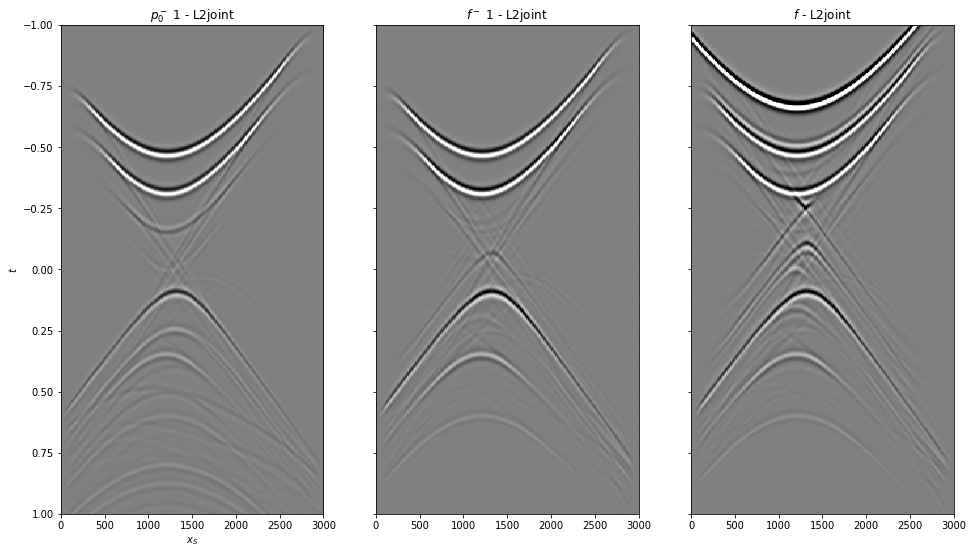

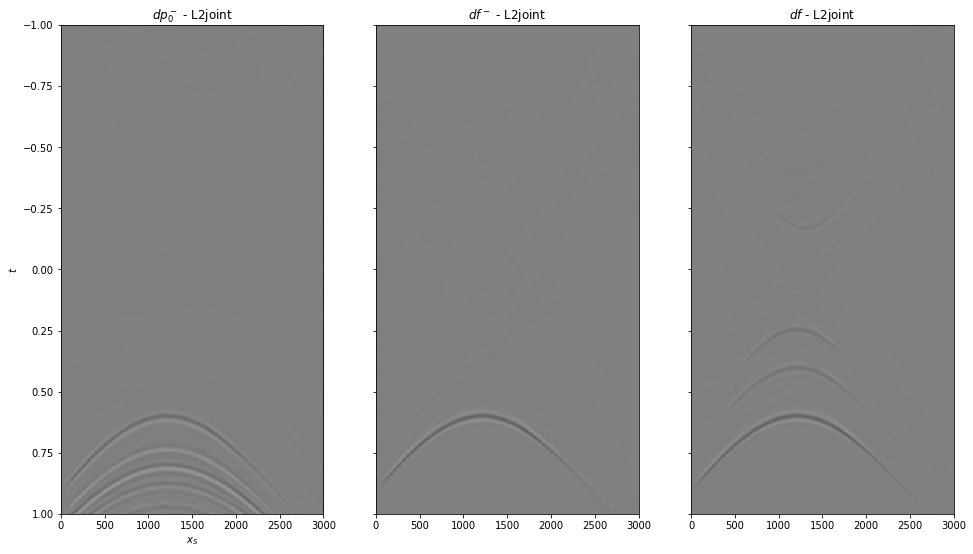

In [24]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_1_minus_l2indip.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$ 1 - L2joint'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_1_minus_l2.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$ 1 - L2joint'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_1_minus_l2.T + f1_1_plus_l2.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f$ - L2joint'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_2_minus_l2indip.T-p0_1_minus_l2indip.T, cmap='gray', 
              vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$dp_0^-$ - L2joint'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_2_minus_l2.T - f1_1_minus_l2.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$df^-$ - L2joint'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow((f1_2_minus_l2.T + f1_2_plus_l2.T) - (f1_1_minus_l2.T + f1_1_plus_l2.T), 
              cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$df$ - L2joint'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1)


(1.5, 0)

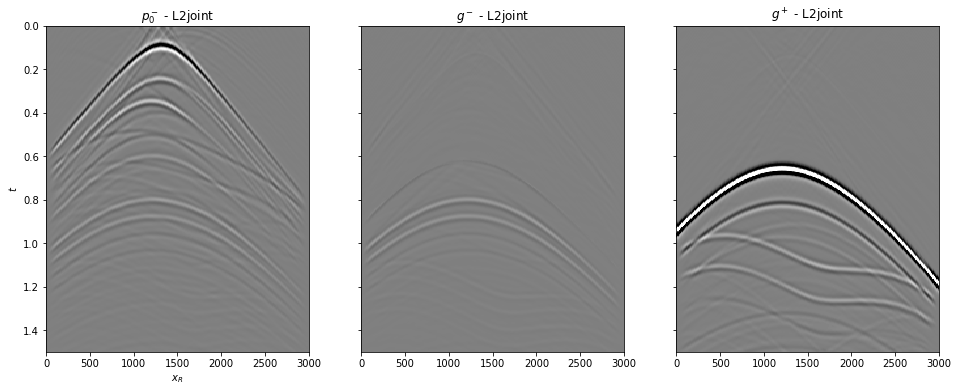

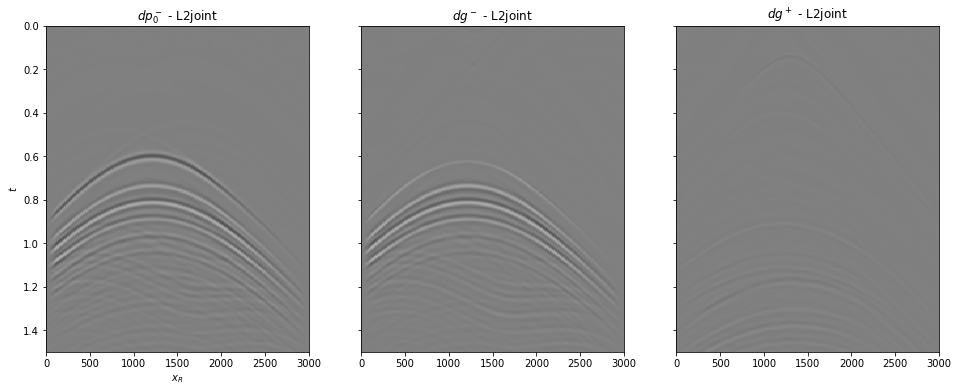

In [25]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 6))
axs[0].imshow(p0_1_minus_l2indip.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$ - L2joint'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0);
axs[1].imshow(g_1_minus_l2.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$ - L2joint'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0);
axs[2].imshow(g_1_plus_l2.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$ - L2joint'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1.5, 0)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 6))
axs[0].imshow(p0_2_minus_l2indip.T - p0_1_minus_l2indip.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$dp_0^-$ - L2joint'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0);
axs[1].imshow(g_2_minus_l2.T - g_1_minus_l2.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$dg^-$ - L2joint'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0);
axs[2].imshow(g_2_plus_l2.T - g_1_plus_l2.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$dg^+$ - L2joint'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1.5, 0)

## Joint Marchenko with missing sources

In [26]:
iava1 = np.loadtxt(path0 + 'temp_select_rfrac70.dat', delimiter=',', dtype=int) - 1
iava2 = np.loadtxt(path0 + 'temp_select_rfrac50.dat', delimiter=',', dtype=int) - 1
nsava1=iava1.shape[0]
nsava2=iava2.shape[0]
        
Restrop1 = Restriction(ns*(2*nt-1), iava1, dims=(ns, 2*nt-1), dir=0, dtype='float64')
Restrop2 = Restriction(ns*(2*nt-1), iava2, dims=(ns, 2*nt-1), dir=0, dtype='float64')

In [27]:
Rop1 = MDC(Rtwosided_fft_1[iava1], nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, dtype='complex64')
R1op1 = MDC(R1twosided_fft_1[iava1], nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, dtype='complex64')

Rop2 = MDC(Rtwosided_fft_2[iava2], nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, dtype='complex64')
R1op2 = MDC(R1twosided_fft_2[iava2], nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, dtype='complex64')

Wop = Diagonal(w.flatten())
WSop1 = Diagonal(w[iava1].flatten())
WSop2 = Diagonal(w[iava2].flatten())

Mop1 = VStack([HStack([Restrop1, -1*WSop1*Rop1]),
               HStack([-1*WSop1*R1op1, Restrop1])])*BlockDiag([Wop, Wop])
Mop2 = VStack([HStack([Restrop2, -1*WSop2*Rop2]),
               HStack([-1*WSop2*R1op2, Restrop2])])*BlockDiag([Wop, Wop])
SumOp = VStack([HStack([Identity(2*(2*nt-1)*nr), Identity(2*(2*nt-1)*nr), Zero(2*(2*nt-1)*nr)]),
                HStack([Identity(2*(2*nt-1)*nr), Zero(2*(2*nt-1)*nr), Identity(2*(2*nt-1)*nr)])])
Mop = BlockDiag([Mop1, Mop2]) * SumOp

Gop1 = VStack([HStack([Restrop1, -1*Rop1]),
               HStack([-1*R1op1, Restrop1])])
Gop2 = VStack([HStack([Restrop2, -1*Rop2]),
               HStack([-1*R1op2, Restrop2])])

# RTM
p0_1_minus_l2sub = Rop1 * fd_plus.flatten()
p0_1_minus_l2sub = p0_1_minus_l2sub.reshape(nsava1, (2*nt-1))

p0_2_minus_l2sub = Rop2 * fd_plus.flatten()
p0_2_minus_l2sub = p0_2_minus_l2sub = Rop2 * fd_plus.flatten()

# Data
d1_sub = WSop1*Rop1*fd_plus.flatten()
d1_sub = np.concatenate((d1_sub.reshape(nsava1, 2*nt-1), np.zeros((nsava1, 2*nt-1))))
d2_sub = WSop2*Rop2*fd_plus.flatten()
d2_sub = np.concatenate((d2_sub.reshape(nsava2, 2*nt-1), np.zeros((nsava2, 2*nt-1))))
d_sub = np.concatenate((d1_sub, d2_sub))

# Inverse
n_iters_l2sub = np.arange(0, n_iter+1, 10)
psnr_l2sub = []
mse_l2sub = []
for i_iter in n_iters_l2sub:
    print(i_iter)
    f1_l2sub = lsqr(Mop, d_sub.flatten(), iter_lim=i_iter, show=False)[0]
    f1_l2sub = f1_l2sub.reshape(6*nr, nt2)
    callback(f1_l2sub, f1_l2, None, psnr_l2sub, mse_l2sub) 

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


In [28]:
f1_tot_l2sub = f1_l2sub + np.concatenate((np.zeros((nr, 2*nt-1)), fd_plus, np.zeros((4*nr, 2*nt-1))))

f1_1_tot_l2sub = f1_tot_l2sub[:2*nr] + f1_tot_l2sub[2*nr:4*nr]
f1_2_tot_l2sub = f1_tot_l2sub[:2*nr] + f1_tot_l2sub[4*nr:]

g_1_l2sub = Gop1*f1_1_tot_l2sub.flatten()
g_1_l2sub = g_1_l2sub.reshape(2*nsava1, (2*nt-1))
g_2_l2sub = Gop2*f1_2_tot_l2sub.flatten()
g_2_l2sub = g_2_l2sub.reshape(2*nsava2, (2*nt-1))

f1_1_minus_l2sub, f1_1_plus_l2sub =  f1_1_tot_l2sub[:nr], f1_1_tot_l2sub[nr:]
f1_2_minus_l2sub, f1_2_plus_l2sub =  f1_2_tot_l2sub[:nr], f1_2_tot_l2sub[nr:]
g_1_minus_l2sub, g_1_plus_l2sub =  -g_1_l2sub[:nsava1], np.fliplr(g_1_l2sub[nsava1:])
g_2_minus_l2sub, g_2_plus_l2sub =  -g_2_l2sub[:nsava2], np.fliplr(g_2_l2sub[nsava2:])

g_1_tot_l2sub = g_1_minus_l2sub + g_1_plus_l2sub
g_2_tot_l2sub = g_2_minus_l2sub + g_2_plus_l2sub

(1, -1)

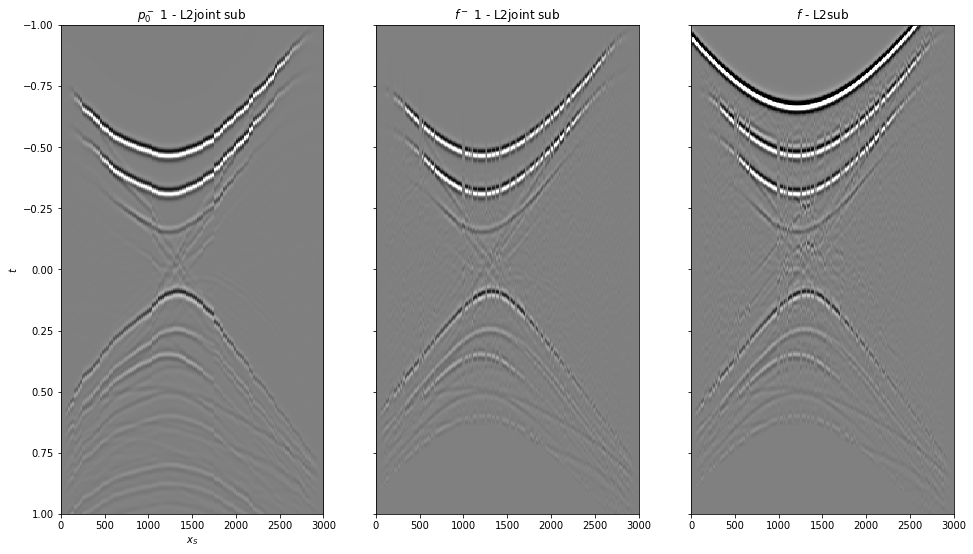

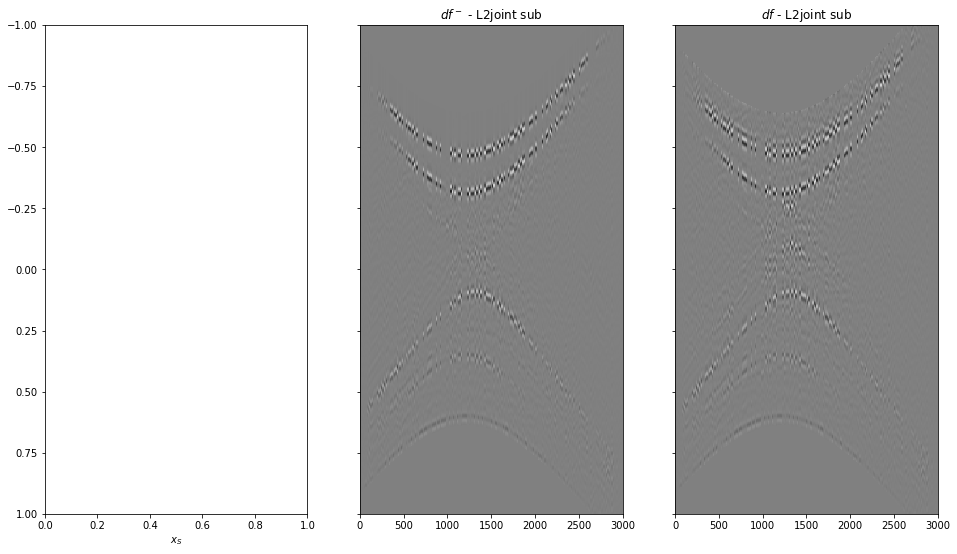

In [29]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_1_minus_l2sub.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$ 1 - L2joint sub'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_1_minus_l2sub.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$ 1 - L2joint sub'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_1_minus_l2sub.T + f1_1_plus_l2sub.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f$ - L2sub'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[1].imshow(f1_2_minus_l2sub.T - f1_1_minus_l2sub.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$df^-$ - L2joint sub'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow((f1_2_minus_l2sub.T + f1_2_plus_l2sub.T) - (f1_1_minus_l2sub.T + f1_1_plus_l2sub.T), 
              cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$df$ - L2joint sub'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1)

## Marchenko with missing sources and Radon sparsity transform

In [30]:
# Radon transform
nwin=31
nwins=9
nover=10
npx=101
pxmax = 1e-3
px = np.linspace(-pxmax, pxmax, npx)

t2=np.concatenate([-t[::-1], t[1:]])
nt2=t2.shape[0]

dimsd = (nr, nt2)
dimss = (nwins*npx, dimsd[1])

# sliding window radon with overlap
RadOp = Radon2D(t2, np.linspace(-ds*nwin//2, ds*nwin//2, nwin), px, centeredh=True, 
                kind='linear', engine='numba')
Slidop = Sliding2D(RadOp, dimss, dimsd, nwin, nover, tapertype='cosine', design=True)
Sparseop = BlockDiag([Slidop, Slidop, Slidop, Slidop])
Sparseop1 = BlockDiag([Slidop, Slidop, Slidop, Slidop, Slidop, Slidop])

Sumop = VStack([HStack([Identity(2*np.prod(dimss)), Identity(2*np.prod(dimss)), Zero(2*np.prod(dimss))]),
                HStack([Identity(2*np.prod(dimss)), Zero(2*np.prod(dimss)), Identity(2*np.prod(dimss))])])

Mop_radon = BlockDiag([Mop1, Mop2]) * Sparseop * Sumop
dottest(Mop_radon, 2*(nsava1+nsava2)*nt2, 6*np.prod(dimss), verb=True);

Dot test passed, v^T(Opu)=-9512.716182 - u^T(Op^Tv)=-9512.716182


Forward and adjoint Radon

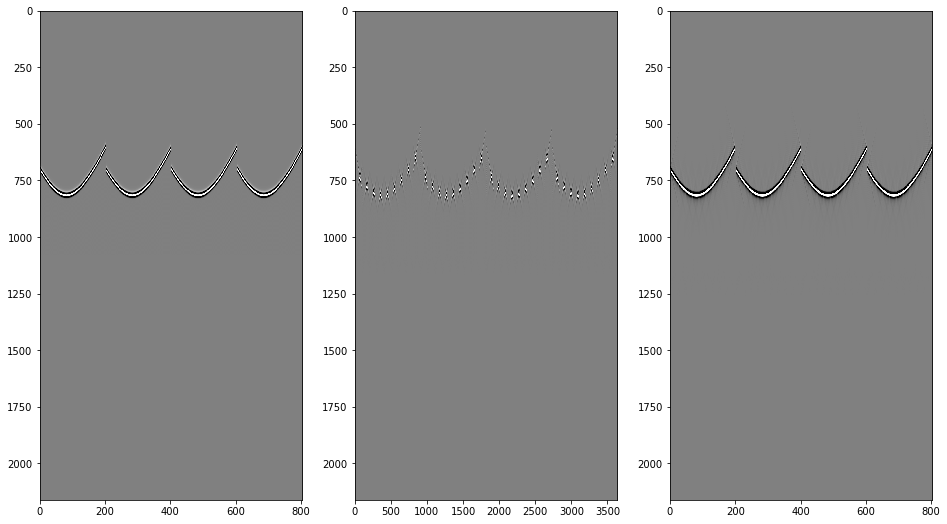

In [31]:
fd_plus1 = np.concatenate([fd_plus, fd_plus, fd_plus, fd_plus])
fd_plus1_radon = Sparseop.H*fd_plus1.flatten()
fd_plus2_radon = Sparseop * fd_plus1_radon

fd_plus1_radon = fd_plus1_radon.reshape(4*npx*nwins, nt2)
fd_plus2_radon = fd_plus2_radon.reshape(4*nr, nt2)

fig, axs = plt.subplots(1, 3, figsize=(16, 9))
axs[0].imshow(fd_plus1.T, cmap='gray', vmin=-5e-1, vmax=5e-1)
axs[0].axis('tight')
axs[1].imshow(fd_plus1_radon.T, cmap='gray', vmin=-5e0, vmax=5e0)
axs[1].axis('tight');
axs[2].imshow(fd_plus2_radon.T, cmap='gray', vmin=-5e1, vmax=5e1)
axs[2].axis('tight');

And on one of the previously found solutions (upgoing focusing function)

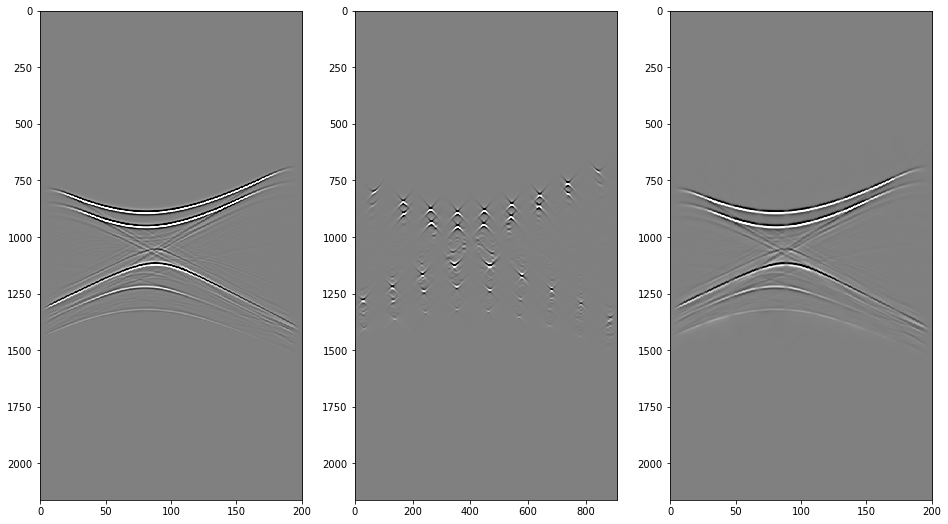

In [32]:
f1_minus_radon = Slidop.H * f1_1_minus_l2.flatten()
f1_minus_rec = Slidop * f1_minus_radon
f1_minus_radon = f1_minus_radon.reshape(npx*nwins, nt2)
f1_minus_rec = f1_minus_rec.reshape(nr, nt2)

fig, axs = plt.subplots(1, 3, figsize=(16, 9))
axs[0].imshow(f1_1_minus_l2.T, cmap='gray', vmin=-5e-1, vmax=5e-1)
axs[0].axis('tight')
axs[1].imshow(f1_minus_radon.T, cmap='gray', vmin=-5e0, vmax=5e0)
axs[1].axis('tight')
axs[2].imshow(f1_minus_rec.T, cmap='gray', vmin=-1e2, vmax=1e2)
axs[2].axis('tight');

L2 Inversion

In [33]:
# Inverse
n_iters_l2radon = np.arange(0, n_iter+1, 10)
psnr_l2radon = []
mse_l2radon = []
for i_iter in n_iters_l2radon:
    print(i_iter)
    f1_l2radon = lsqr(Mop_radon, d_sub.flatten(), iter_lim=i_iter, show=False)[0]
    f1_l2radon = Sparseop1 * f1_l2radon
    f1_l2radon = f1_l2radon.reshape(6*nr, nt2)
    callback(f1_l2radon, f1_l2, None, psnr_l2radon, mse_l2radon) 

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


In [34]:
f1_tot_l2radon = f1_l2radon + np.concatenate((np.zeros((nr, 2*nt-1)), fd_plus, np.zeros((4*nr, 2*nt-1))))

f1_1_tot_l2radon = f1_tot_l2radon[:2*nr] + f1_tot_l2radon[2*nr:4*nr]
f1_2_tot_l2radon = f1_tot_l2radon[:2*nr] + f1_tot_l2radon[4*nr:]

g_1_tot_l2radon = Gop1*f1_1_tot_l2radon.flatten()
g_1_tot_l2radon = g_1_tot_l2radon.reshape(2*nsava1, (2*nt-1))
g_2_tot_l2radon = Gop2*f1_1_tot_l2radon.flatten()
g_2_tot_l2radon = g_2_tot_l2radon.reshape(2*nsava2, (2*nt-1))

f1_1_minus_l2radon, f1_1_plus_l2radon = f1_1_tot_l2radon[:nr], f1_1_tot_l2radon[nr:]
f1_2_minus_l2radon, f1_2_plus_l2radon = f1_2_tot_l2radon[:nr], f1_2_tot_l2radon[nr:]
g_1_minus_l2radon, g_1_plus_l2radon = -g_1_tot_l2radon[:nsava1], np.fliplr(g_1_tot_l2radon[nsava1:])
g_2_minus_l2radon, g_2_plus_l2radon = -g_2_tot_l2radon[:nsava2], np.fliplr(g_2_tot_l2radon[nsava2:])

g_1_tot_l2radon = g_1_minus_l2radon + g_1_plus_l2radon
g_2_tot_l2radon = g_2_minus_l2radon + g_2_plus_l2radon

(1, -1)

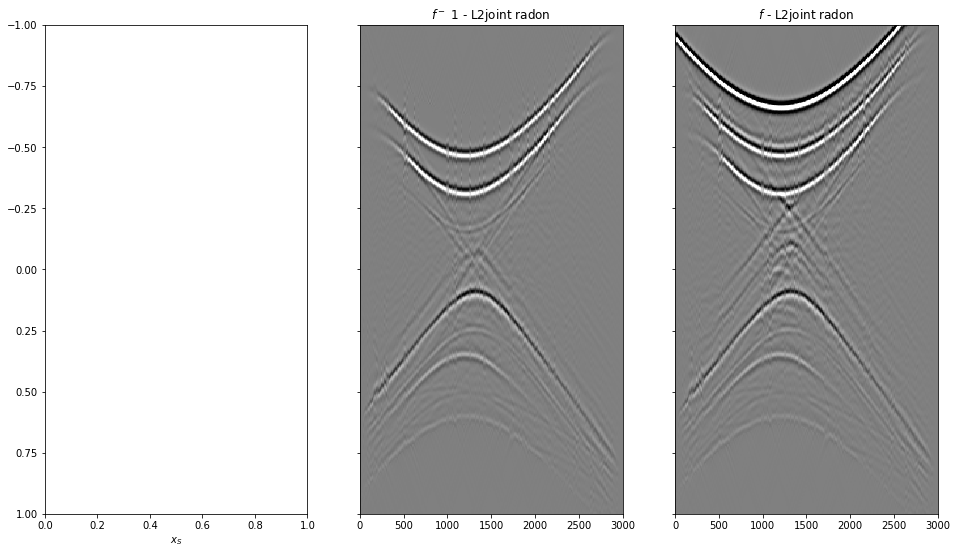

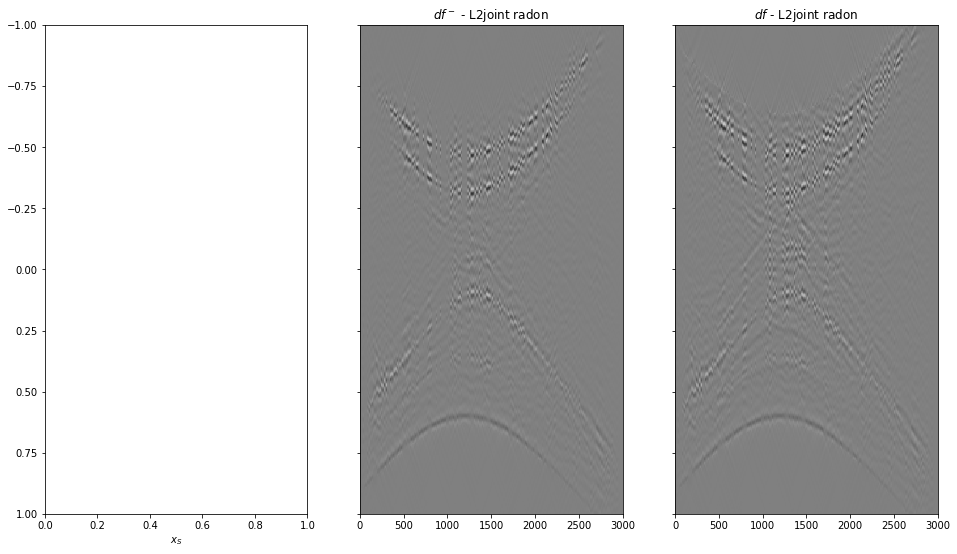

In [35]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[1].imshow(f1_1_minus_l2radon.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$ 1 - L2joint radon'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_1_minus_l2radon.T + f1_1_plus_l2radon.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f$ - L2joint radon'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[1].imshow(f1_2_minus_l2radon.T - f1_1_minus_l2radon.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$df^-$ - L2joint radon'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow((f1_2_minus_l2radon.T + f1_2_plus_l2radon.T) - (f1_1_minus_l2radon.T + f1_1_plus_l2radon.T), 
              cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$df$ - L2joint radon'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1)

Sparse inversion with FISTA

In [36]:
mse_l1radon = []
psnr_l1radon = []
f1_l1radon = FISTA(Mop_radon, d_sub.flatten(), eps=3e-2, niter=n_iter,
                   alpha=2.129944e-04, #eigsiter=4, eigstol=1e-3, 
                   tol=1e-2, returninfo=False, show=True,
                   callback=lambda x: callback(x, f1_l2, Sparseop1, psnr_l1radon, mse_l1radon))[0]

f1_l1radon = Sparseop1 * f1_l1radon
f1_l1radon = f1_l1radon.reshape(6*nr, nt2)

FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 1045924 rows and 11786094 cols
eps = 3.000000e-02	tol = 1.000000e-02	niter = 200
alpha = 2.129944e-04	thresh = 3.194916e-06
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1   0.00000e+00   1.478e+03   1.482e+03   2.273e-01
     2   0.00000e+00   1.289e+03   1.295e+03   2.048e-01
     3   0.00000e+00   1.091e+03   1.100e+03   2.386e-01
     4   0.00000e+00   8.991e+02   9.120e+02   2.605e-01
     5   0.00000e+00   7.249e+02   7.414e+02   2.724e-01
     6   0.00000e+00   5.737e+02   5.938e+02   2.759e-01
     7   0.00000e+00   4.474e+02   4.711e+02   2.726e-01
     8   0.00000e+00   3.452e+02   3.724e+02   2.641e-01
     9   0.00000e+00   2.649e+02   2.952e+02   2.518e-01
    10   0.00000e+00   2.032e+02   2.365e+02   2.367e-01
    11   0.00000e+00   1.567e+02   1.928e+02   2.202e-01
    21   0.00

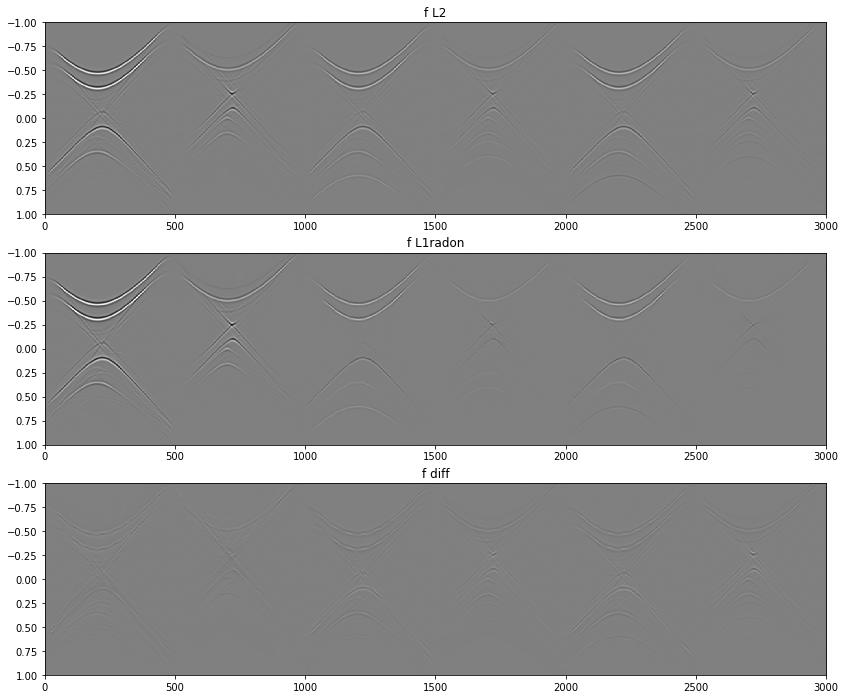

In [37]:
fig, axs = plt.subplots(3, 1, figsize=(14, 12))
axs[0].imshow(f1_l2.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].axis('tight')
axs[0].set_title('f L2')
axs[0].set_ylim(1, -1)
axs[1].imshow(f1_l1radon.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].axis('tight')
axs[1].set_title('f L1radon')
axs[1].set_ylim(1, -1)
axs[2].imshow(f1_l2.T - f1_l1radon.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].axis('tight')
axs[2].set_title('f diff')
axs[2].set_ylim(1, -1);

In [38]:
f1_tot_l1radon = f1_l1radon + np.concatenate((np.zeros((nr, 2*nt-1)), fd_plus, np.zeros((4*nr, 2*nt-1))))

f1_1_tot_l1radon = f1_tot_l1radon[:2*nr] + f1_tot_l1radon[2*nr:4*nr]
f1_2_tot_l1radon = f1_tot_l1radon[:2*nr] + f1_tot_l1radon[4*nr:]

g_1_tot_l1radon = Gop1*f1_1_tot_l1radon.flatten()
g_1_tot_l1radon = g_1_tot_l1radon.reshape(2*nsava1, (2*nt-1))
g_2_tot_l1radon = Gop2*f1_1_tot_l1radon.flatten()
g_2_tot_l1radon = g_2_tot_l1radon.reshape(2*nsava2, (2*nt-1))

f1_1_minus_l1radon, f1_1_plus_l1radon = f1_1_tot_l1radon[:nr], f1_1_tot_l1radon[nr:]
f1_2_minus_l1radon, f1_2_plus_l1radon = f1_2_tot_l1radon[:nr], f1_2_tot_l1radon[nr:]
g_1_minus_l1radon, g_1_plus_l1radon = -g_1_tot_l1radon[:nsava1], np.fliplr(g_1_tot_l1radon[nsava1:])
g_2_minus_l1radon, g_2_plus_l1radon = -g_2_tot_l1radon[:nsava2], np.fliplr(g_2_tot_l1radon[nsava2:])

g_1_tot_l1radon = g_1_minus_l1radon + g_1_plus_l1radon
g_2_tot_l1radon = g_2_minus_l1radon + g_2_plus_l1radon

(1, -1)

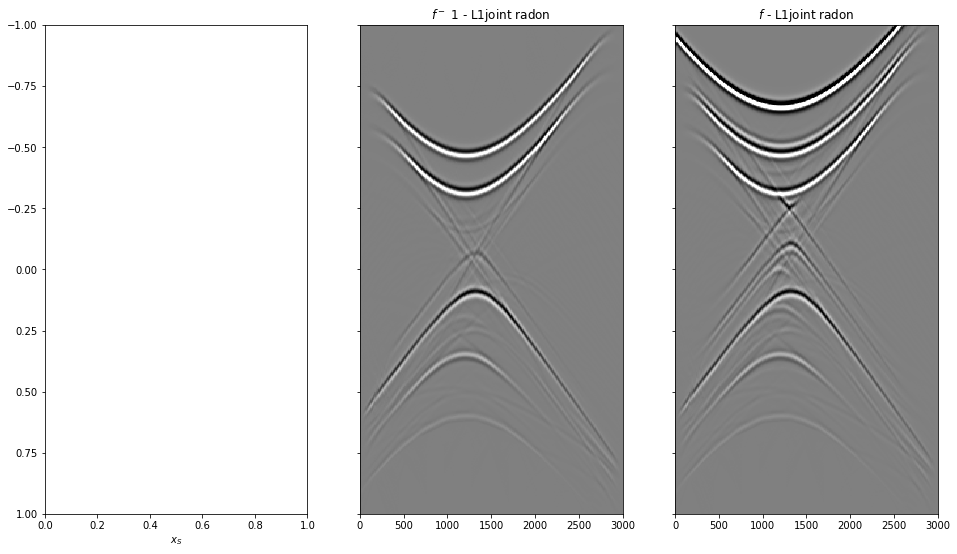

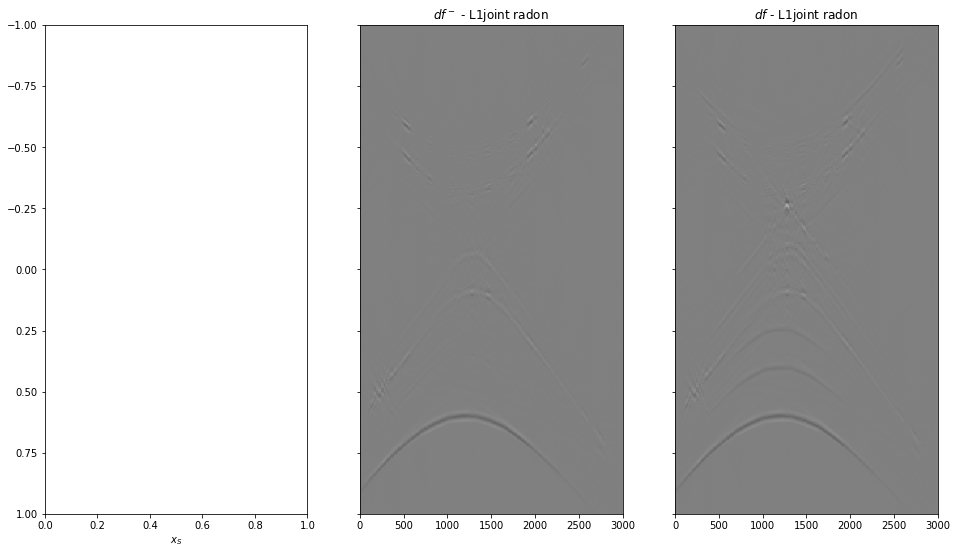

In [39]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[1].imshow(f1_1_minus_l1radon.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$ 1 - L1joint radon'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_1_minus_l1radon.T + f1_1_plus_l1radon.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f$ - L1joint radon'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[1].imshow(f1_2_minus_l1radon.T - f1_1_minus_l1radon.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$df^-$ - L1joint radon'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow((f1_2_minus_l1radon.T + f1_2_plus_l1radon.T) - (f1_1_minus_l1radon.T + f1_1_plus_l1radon.T), 
              cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$df$ - L1joint radon'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1)

Sparse inversion with SPGL1

In [40]:
#f1_l1radon_spgl1 = SPGL1(Mop_radon, d_sub.flatten(), iter_lim=n_iter, sigma=0, 
#                         dec_tol=5e-2, opt_tol=5e-2, verbosity=2)[0]
#f1_l1radon_spgl1 = Sparseop1 * f1_l1radon_spgl1
#f1_l1radon_spgl1 = f1_l1radon_spgl1.reshape(6*nr, nt2)

# Inverse
n_iters_l1radon_spgl1 = np.arange(0, n_iter+1, 10)
psnr_l1radon_spgl1 = []
mse_l1radon_spgl1 = []
for i_iter in n_iters_l2sub:
    print(i_iter)
    f1_l1radon_spgl1 = SPGL1(Mop_radon, d_sub.flatten(), iter_lim=i_iter, sigma=0, 
                             dec_tol=5e-2, opt_tol=5e-2, verbosity=0)[0]
    f1_l1radon_spgl1 = Sparseop1 * f1_l1radon_spgl1
    f1_l1radon_spgl1 = f1_l1radon_spgl1.reshape(6*nr, nt2)
    callback(f1_l1radon_spgl1, f1_l2, None, psnr_l1radon_spgl1, mse_l1radon_spgl1) 

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


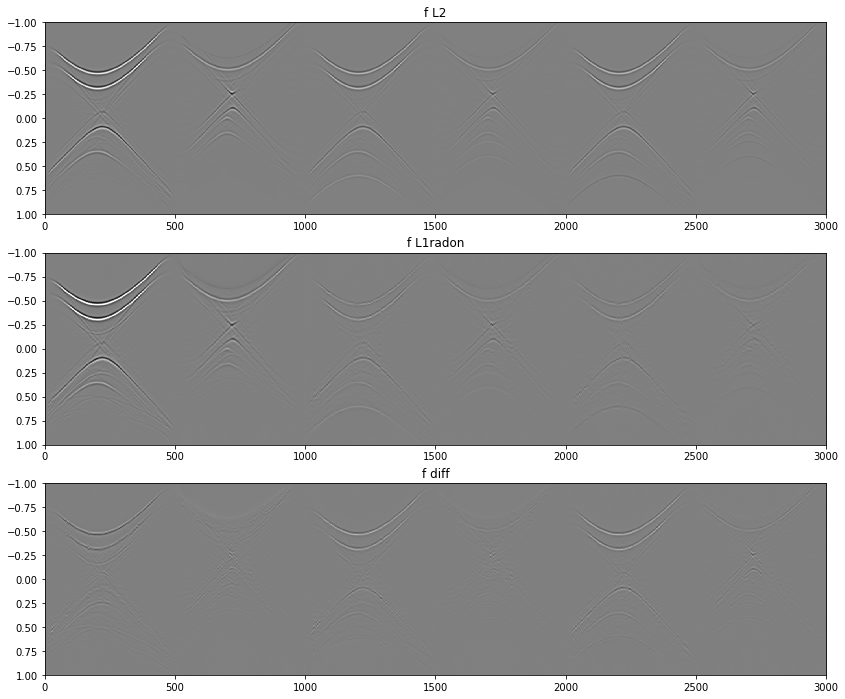

In [41]:
fig, axs = plt.subplots(3, 1, figsize=(14, 12))
axs[0].imshow(f1_l2.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].axis('tight')
axs[0].set_title('f L2')
axs[0].set_ylim(1, -1)
axs[1].imshow(f1_l1radon_spgl1.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].axis('tight')
axs[1].set_title('f L1radon')
axs[1].set_ylim(1, -1)
axs[2].imshow(f1_l2.T - f1_l1radon_spgl1.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].axis('tight')
axs[2].set_title('f diff')
axs[2].set_ylim(1, -1);

In [42]:
f1_tot_l1radon_spgl1 = f1_l1radon_spgl1 + np.concatenate((np.zeros((nr, 2*nt-1)), fd_plus, np.zeros((4*nr, 2*nt-1))))

f1_1_tot_l1radon_spgl1 = f1_tot_l1radon_spgl1[:2*nr] + f1_tot_l1radon_spgl1[2*nr:4*nr]
f1_2_tot_l1radon_spgl1 = f1_tot_l1radon_spgl1[:2*nr] + f1_tot_l1radon_spgl1[4*nr:]

g_1_tot_l1radon_spgl1 = Gop1*f1_1_tot_l1radon_spgl1.flatten()
g_1_tot_l1radon_spgl1 = g_1_tot_l1radon_spgl1.reshape(2*nsava1, (2*nt-1))
g_2_tot_l1radon_spgl1 = Gop2*f1_1_tot_l1radon_spgl1.flatten()
g_2_tot_l1radon_spgl1 = g_2_tot_l1radon_spgl1.reshape(2*nsava2, (2*nt-1))

f1_1_minus_l1radon_spgl1, f1_1_plus_l1radon_spgl1 = f1_1_tot_l1radon_spgl1[:nr], f1_1_tot_l1radon_spgl1[nr:]
f1_2_minus_l1radon_spgl1, f1_2_plus_l1radon_spgl1 = f1_2_tot_l1radon_spgl1[:nr], f1_2_tot_l1radon_spgl1[nr:]
g_1_minus_l1radon_spgl1, g_1_plus_l1radon_spgl1 = -g_1_tot_l1radon_spgl1[:nsava1], np.fliplr(g_1_tot_l1radon_spgl1[nsava1:])
g_2_minus_l1radon_spgl1, g_2_plus_l1radon_spgl1 = -g_2_tot_l1radon_spgl1[:nsava2], np.fliplr(g_2_tot_l1radon_spgl1[nsava2:])

g_1_tot_l1radon_spgl1 = g_1_minus_l1radon_spgl1 + g_1_plus_l1radon_spgl1
g_2_tot_l1radon_spgl1 = g_2_minus_l1radon_spgl1 + g_2_plus_l1radon_spgl1

(1, -1)

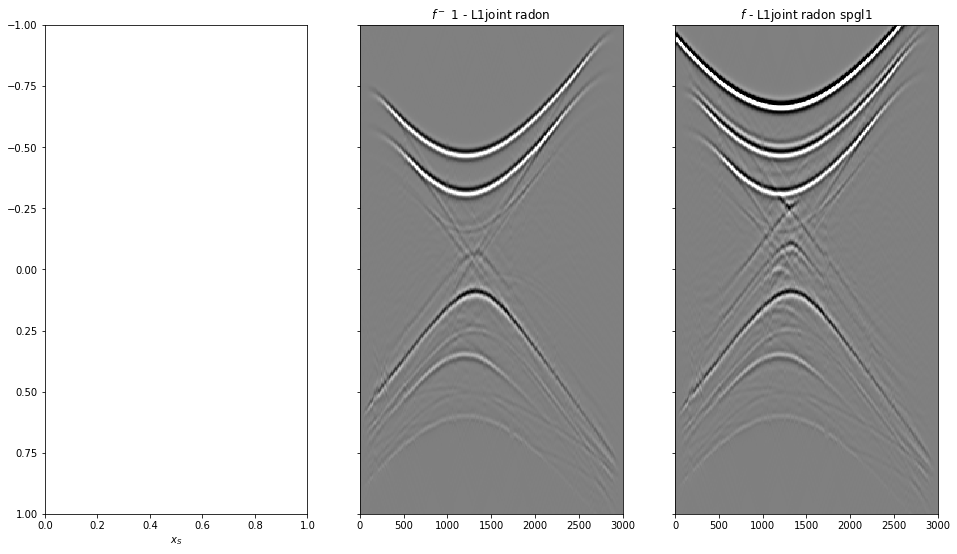

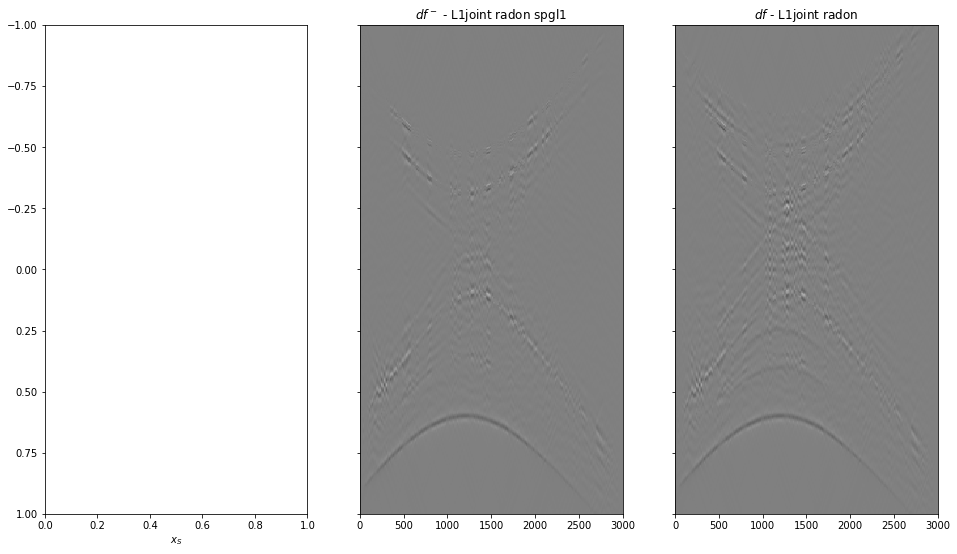

In [43]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[1].imshow(f1_1_minus_l1radon_spgl1.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$ 1 - L1joint radon'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_1_minus_l1radon_spgl1.T + f1_1_plus_l1radon_spgl1.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f$ - L1joint radon spgl1'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[1].imshow(f1_2_minus_l1radon_spgl1.T - f1_1_minus_l1radon_spgl1.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$df^-$ - L1joint radon spgl1'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow((f1_2_minus_l1radon_spgl1.T + f1_2_plus_l1radon_spgl1.T) - 
              (f1_1_minus_l1radon_spgl1.T + f1_1_plus_l1radon_spgl1.T), 
              cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$df$ - L1joint radon'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1)

Compare with benchmark focusing functions (from regularly sampled data)

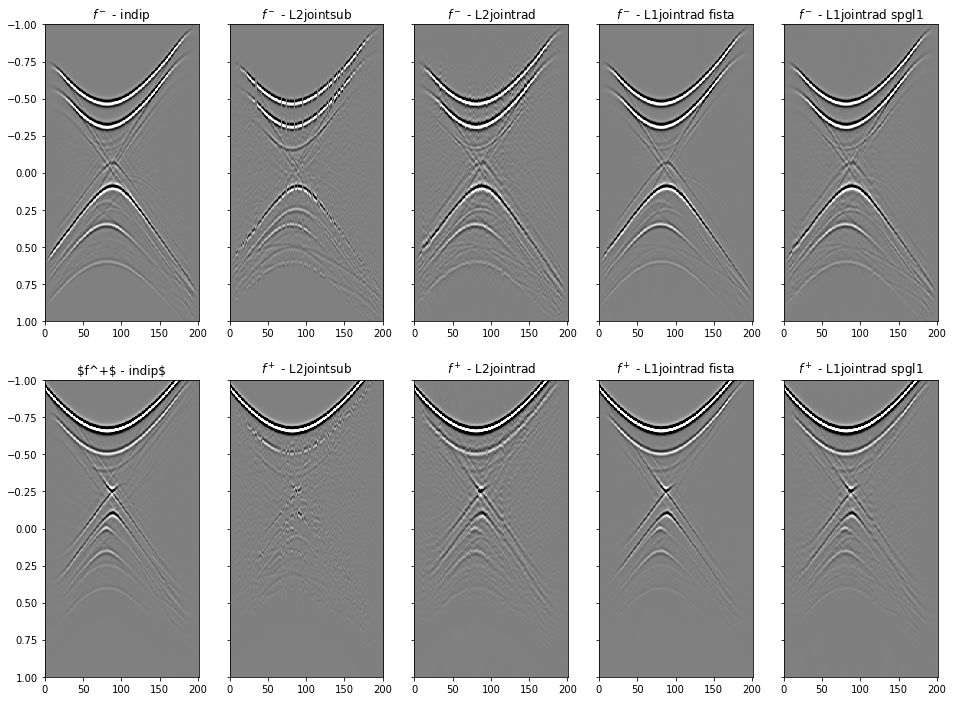

In [44]:
fig, axs = plt.subplots(2, 5, sharey=True, figsize=(16, 12))
axs[0][0].imshow(f1_1_minus_l2indip.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[0][0].set_title(r'$f^-$ - indip')
axs[0][0].axis('tight')
axs[0][0].set_ylim(1, -1);
axs[0][1].imshow(f1_1_minus_l2sub.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[0][1].set_title(r'$f^-$ - L2jointsub')
axs[0][1].axis('tight')
axs[0][1].set_ylim(1, -1)
axs[0][2].imshow(f1_1_minus_l2radon.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[0][2].set_title(r'$f^-$ - L2jointrad')
axs[0][2].axis('tight')
axs[0][2].set_ylim(1, -1)
axs[0][3].imshow(f1_1_minus_l1radon.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[0][3].set_title(r'$f^-$ - L1jointrad fista')
axs[0][3].axis('tight')
axs[0][3].set_ylim(1, -1)
axs[0][4].imshow(f1_1_minus_l1radon_spgl1.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[0][4].set_title(r'$f^-$ - L1jointrad spgl1')
axs[0][4].axis('tight')
axs[0][4].set_ylim(1, -1)
axs[1][0].imshow(f1_1_plus_l2indip.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[1][0].set_title(r'$f^+$ - indip$')
axs[1][0].axis('tight')
axs[1][0].set_ylim(1, -1);
axs[1][1].imshow(f1_1_plus_l2sub.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[1][1].set_title(r'$f^+$ - L2jointsub')
axs[1][1].axis('tight')
axs[1][1].set_ylim(1, -1);
axs[1][2].imshow(f1_1_plus_l2radon.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[1][2].set_title(r'$f^+$ - L2jointrad')
axs[1][2].axis('tight')
axs[1][2].set_ylim(1, -1);
axs[1][3].imshow(f1_1_plus_l1radon.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[1][3].set_title(r'$f^+$ - L1jointrad fista')
axs[1][3].axis('tight')
axs[1][3].set_ylim(1, -1)
axs[1][4].imshow(f1_1_plus_l1radon_spgl1.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[1][4].set_title(r'$f^+$ - L1jointrad spgl1')
axs[1][4].axis('tight')
axs[1][4].set_ylim(1, -1);

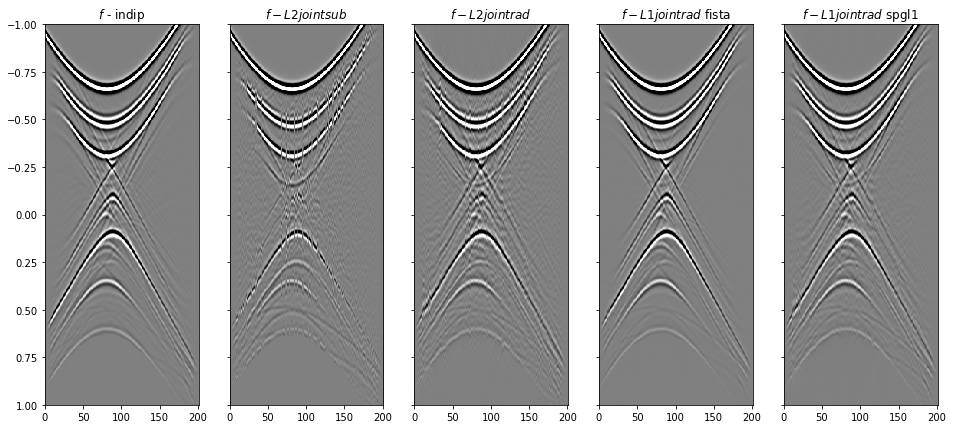

In [45]:
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(16, 7))
axs[0].imshow(f1_1_minus_l2indip.T + f1_1_plus_l2indip.T, cmap='gray',
              vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[0].set_title(r'$f$ - indip')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_1_minus_l2sub.T + f1_1_plus_l2sub.T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[1].set_title(r'$f - L2jointsub$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1)
axs[2].imshow(f1_1_minus_l2radon.T + f1_1_plus_l2radon.T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[2].set_title(r'$f - L2jointrad$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1)
axs[3].imshow(f1_1_minus_l1radon.T + f1_1_plus_l1radon.T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[3].set_title(r'$f - L1jointrad$ fista')
axs[3].axis('tight')
axs[3].set_ylim(1, -1)
axs[4].imshow(f1_1_minus_l1radon_spgl1.T + f1_1_plus_l1radon_spgl1.T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[4].set_title(r'$f - L1jointrad$ spgl1')
axs[4].axis('tight')
axs[4].set_ylim(1, -1);

Finally we compare the GF's estimates

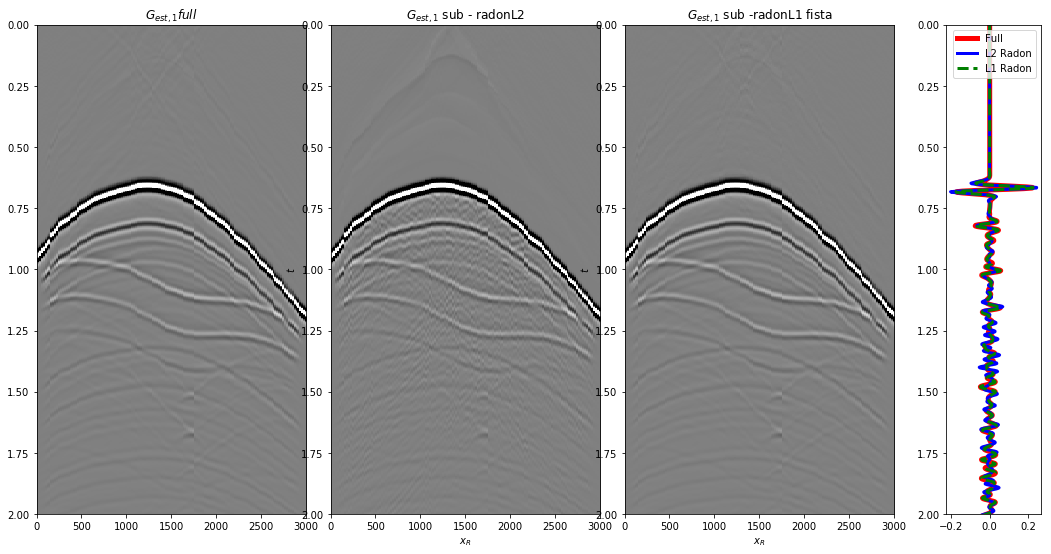

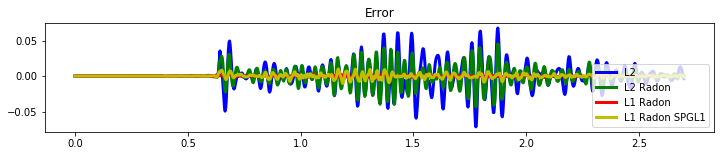

In [46]:
fig = plt.figure(figsize=(18,9))
ax1 = plt.subplot2grid((1, 7), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 7), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 7), (0, 4), colspan=2)
ax4 = plt.subplot2grid((1, 7), (0, 6), colspan=2)
ax5 = plt.subplot2grid((1, 9), (0, 8))

ax1.imshow(g_1_tot_l2[iava1].T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax1.set_title(r'$G_{est,1} full $'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(2, 0)
ax2.imshow(g_1_tot_l2radon.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax2.set_title(r'$G_{est,1}$ sub - radonL2'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(2, 0)
ax3.imshow(g_1_tot_l1radon.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax3.set_title(r'$G_{est,1}$ sub -radonL1 fista'), ax3.set_xlabel(r'$x_R$'), ax3.set_ylabel(r'$t$')
ax3.axis('tight')
ax3.set_ylim(2, 0)
ax4.imshow(g_1_tot_l1radon_spgl1.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
           extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax4.set_title(r'$G_{est,1}$ sub -radonL1 spgl1'), ax4.set_xlabel(r'$x_R$'), ax4.set_ylabel(r'$t$')
ax4.axis('tight')
ax4.set_ylim(2, 0)
ax5.plot(t**3*g_1_tot_l2[iava1][nr//4, nt-1:]/g_1_tot_l2.max(), t, 'r', lw=5, label='Full')
ax5.plot(t**3*g_1_tot_l2radon[nr//4, nt-1:]/g_1_tot_l2.max(), t, 'b', lw=3, label='L2 Radon')
ax5.plot(t**3*g_1_tot_l1radon[nr//4, nt-1:]/g_1_tot_l2.max(), t, '--g', lw=3, label='L1 Radon')
ax5.set_ylim(2, 0)
ax5.legend()

plt.figure(figsize=(12, 2))
plt.plot(t, t**3*g_1_tot_l2[iava1][nr//4, nt-1:]/g_1_tot_l2.max() - t**3*g_1_tot_l2sub[nr//4, nt-1:]/g_1_tot_l2.max(), 
         'b', lw=3, label='L2')
plt.plot(t, t**3*g_1_tot_l2[iava1][nr//4, nt-1:]/g_1_tot_l2.max() - t**3*g_1_tot_l2radon[nr//4, nt-1:]/g_1_tot_l2.max(), 
         'g', lw=3, label='L2 Radon')
plt.plot(t, t**3*g_1_tot_l2[iava1][nr//4, nt-1:]/g_1_tot_l2.max() - t**3*g_1_tot_l1radon[nr//4, nt-1:]/g_1_tot_l2.max(), 
         'r', lw=3, label='L1 Radon')
plt.plot(t, t**3*g_1_tot_l2[iava1][nr//4, nt-1:]/g_1_tot_l2.max() - t**3*g_1_tot_l1radon_spgl1[nr//4, nt-1:]/g_1_tot_l2.max(), 
         'y', lw=3, label='L1 Radon SPGL1')
plt.title('Error')
plt.legend();

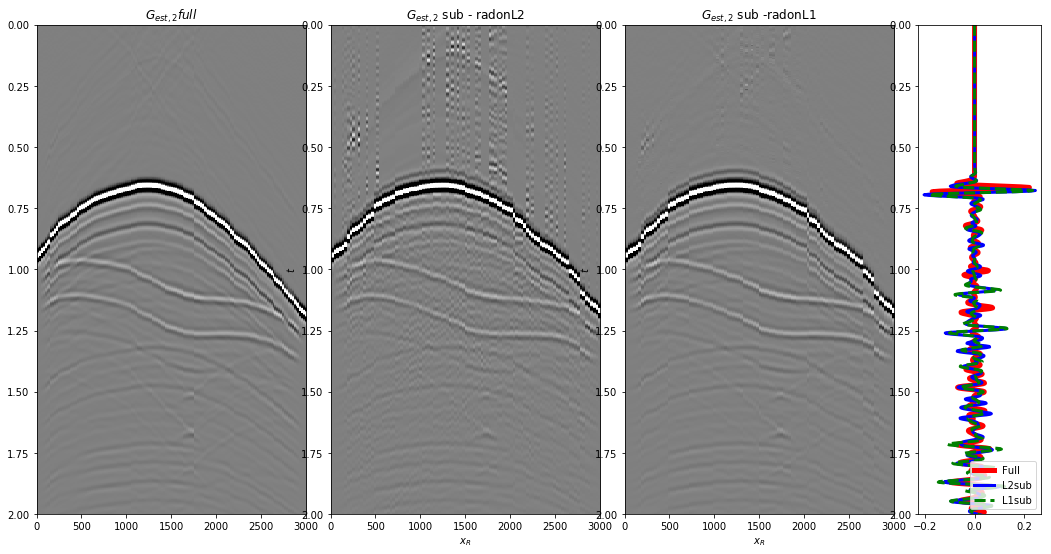

In [47]:
fig = plt.figure(figsize=(18,9))
ax1 = plt.subplot2grid((1, 7), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 7), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 7), (0, 4), colspan=2)
ax4 = plt.subplot2grid((1, 7), (0, 6))

ax1.imshow(g_2_tot_l2[iava1].T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax1.set_title(r'$G_{est,2} full $'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(2, 0)
ax2.imshow(g_2_tot_l2radon.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax2.set_title(r'$G_{est,2}$ sub - radonL2'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(2, 0)
ax3.imshow(g_2_tot_l1radon.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax3.set_title(r'$G_{est,2}$ sub -radonL1'), ax3.set_xlabel(r'$x_R$'), ax3.set_ylabel(r'$t$')
ax3.axis('tight')
ax3.set_ylim(2, 0)
ax4.plot(t**3*g_2_tot_l2[iava1][nr//4, nt-1:]/g_2_tot_l2.max(), t, 'r', lw=5, label='Full')
ax4.plot(t**3*g_2_tot_l2radon[nr//4, nt-1:]/g_2_tot_l2.max(), t, 'b', lw=3, label='L2sub')
ax4.plot(t**3*g_2_tot_l1radon[nr//4, nt-1:]/g_2_tot_l2.max(), t, '--g', lw=3, label='L1sub')
ax4.set_ylim(2, 0);
ax4.legend();

# Cannot check the error because of the shift in the estimate due to the fact that the direct wave is 
# made using the baseline velocity model..

Finally we analyse convergence

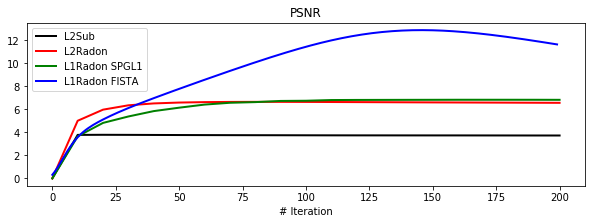

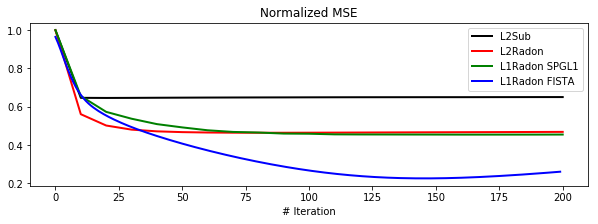

In [62]:
plt.figure(figsize=(10, 3))
plt.plot(n_iters_l2sub, psnr_l2sub, 'k', lw=2, label='L2Sub')
plt.plot(n_iters_l2radon, psnr_l2radon, 'r', lw=2, label='L2Radon')
plt.plot(n_iters_l1radon_spgl1, psnr_l1radon_spgl1, 'g', lw=2, label='L1Radon SPGL1')
plt.plot(psnr_l1radon, 'b', lw=2, label='L1Radon FISTA')
plt.legend()
plt.xlabel('# Iteration')
plt.title('PSNR');

plt.figure(figsize=(10, 3))
plt.plot(n_iters_l2sub, mse_l2sub / mse_l2, 'k', lw=2, label='L2Sub')
plt.plot(n_iters_l2radon, mse_l2radon / mse_l2, 'r', lw=2, label='L2Radon')
plt.plot(n_iters_l1radon_spgl1, mse_l1radon_spgl1 / mse_l2, 'g', lw=2, label='L1Radon SPGL1')
plt.plot(mse_l1radon / mse_l2, 'b', lw=2, label='L1Radon FISTA')
plt.legend()
plt.xlabel('# Iteration')
plt.title('Normalized MSE');

## Early stoppings

Finally we try with an early stopping and see how the results compare

In [49]:
psnr_early = []
mse_early = []
f1_l1radon_early = FISTA(Mop_radon, d_sub.flatten(), eps=3e-2, niter=30,
                   alpha=2.129944e-04, #eigsiter=4, eigstol=1e-3, 
                   tol=1e-2, returninfo=False, show=True,
                   callback=lambda x: callback(x, f1_l2, Sparseop1, psnr_early, mse_early))[0]
#f1_l1radon_early = FISTA(Mop_radon, d_sub.flatten(), eps=1e-1, niter=50,
#                   alpha=2.129944e-04, #eigsiter=4, eigstol=1e-3, 
#                   tol=1e-2, returninfo=False, show=True,
#                   callback=lambda x: callback(x, f1_l2, Sparseop1, psnr_early, mse_early))[0]
f1_l1radon_early = Sparseop1 * f1_l1radon_early
f1_l1radon_early = f1_l1radon_early.reshape(6*nr, nt2)

FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 1045924 rows and 11786094 cols
eps = 3.000000e-02	tol = 1.000000e-02	niter = 30
alpha = 2.129944e-04	thresh = 3.194916e-06
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1   0.00000e+00   1.478e+03   1.482e+03   2.273e-01
     2   0.00000e+00   1.289e+03   1.295e+03   2.048e-01
     3   0.00000e+00   1.091e+03   1.100e+03   2.386e-01
     4   0.00000e+00   8.991e+02   9.120e+02   2.605e-01
     5   0.00000e+00   7.249e+02   7.414e+02   2.724e-01
     6   0.00000e+00   5.737e+02   5.938e+02   2.759e-01
     7   0.00000e+00   4.474e+02   4.711e+02   2.726e-01
     8   0.00000e+00   3.452e+02   3.724e+02   2.641e-01
     9   0.00000e+00   2.649e+02   2.952e+02   2.518e-01
    10   0.00000e+00   2.032e+02   2.365e+02   2.367e-01
    11   0.00000e+00   1.567e+02   1.928e+02   2.202e-01
    21   0.000

In [50]:
f1_tot_l1radon_early = f1_l1radon_early + np.concatenate((np.zeros((nr, 2*nt-1)), fd_plus, np.zeros((4*nr, 2*nt-1))))

f1_1_tot_l1radon_early = f1_tot_l1radon_early[:2*nr] + f1_tot_l1radon_early[2*nr:4*nr]
f1_2_tot_l1radon_early = f1_tot_l1radon_early[:2*nr] + f1_tot_l1radon_early[4*nr:]

g_1_tot_l1radon_early = Gop1*f1_1_tot_l1radon_early.flatten()
g_1_tot_l1radon_early = g_1_tot_l1radon_early.reshape(2*nsava1, (2*nt-1))
g_2_tot_l1radon_early = Gop2*f1_1_tot_l1radon_early.flatten()
g_2_tot_l1radon_early = g_2_tot_l1radon_early.reshape(2*nsava2, (2*nt-1))

f1_1_minus_l1radon_early, f1_1_plus_l1radon_early = f1_1_tot_l1radon_early[:nr], f1_1_tot_l1radon_early[nr:]
f1_2_minus_l1radon_early, f1_2_plus_l1radon_early = f1_2_tot_l1radon_early[:nr], f1_2_tot_l1radon_early[nr:]
g_1_minus_l1radon_early, g_1_plus_l1radon_early = -g_1_tot_l1radon_early[:nsava1], np.fliplr(g_1_tot_l1radon_early[nsava1:])
g_2_minus_l1radon_early, g_2_plus_l1radon_early = -g_2_tot_l1radon_early[:nsava2], np.fliplr(g_2_tot_l1radon_early[nsava2:])

g_1_tot_l1radon_early = g_1_minus_l1radon_early + g_1_plus_l1radon_early
g_2_tot_l1radon_early = g_2_minus_l1radon_early + g_2_plus_l1radon_early

In [51]:
f1_l1radon_spgl1_early = SPGL1(Mop_radon, d_sub.flatten(), iter_lim=30, sigma=0, 
                               dec_tol=5e-2, opt_tol=5e-2, verbosity=2)[0]
f1_l1radon_spgl1_early = Sparseop1 * f1_l1radon_spgl1_early
f1_l1radon_spgl1_early = f1_l1radon_spgl1_early.reshape(6*nr, nt2)


SPGL1
No. rows              :  1045924     
No. columns           : 11786094

Initial tau           : 0.00e+00     
Two-norm of b         : 5.85e+01

Optimality tol        : 5.00e-02     
Target objective      : 0.00e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :       30

iterr      Objective   Relative Gap  Rel Error      gnorm   stepg   nnz_x   nnz_g     tau

    0  5.8488696e+01  0.0000000e+00   1.00e+00  3.691e+01     0.0       0       0  9.2693787e+01
    1  4.6381801e+01  4.8913343e+00   1.00e+00  4.804e+01    -0.6     360       0               
    2  5.2518216e+01  3.8998922e+00   1.00e+00  5.422e+01     0.0     234       1               
    3  4.5867131e+01  2.3671519e+00   1.00e+00  2.545e+01     0.0     248       0               
    4  3.9417163e+01  1.1061127e+00   1.00e+00  1.422e+01     0.0     255       1               
    5  3.6910201e+01  5.8631852e-01   1.00e+00  1.004e+01     0.0     262       0               
    6  3.6039797e+01  5.2514436e

In [52]:
f1_tot_l1radon_spgl1_early = f1_l1radon_spgl1_early + np.concatenate((np.zeros((nr, 2*nt-1)), fd_plus, np.zeros((4*nr, 2*nt-1))))

f1_1_tot_l1radon_spgl1_early = f1_tot_l1radon_spgl1_early[:2*nr] + f1_tot_l1radon_spgl1_early[2*nr:4*nr]
f1_2_tot_l1radon_spgl1_early = f1_tot_l1radon_spgl1_early[:2*nr] + f1_tot_l1radon_spgl1_early[4*nr:]

g_1_tot_l1radon_spgl1_early = Gop1*f1_1_tot_l1radon_spgl1_early.flatten()
g_1_tot_l1radon_spgl1_early = g_1_tot_l1radon_spgl1_early.reshape(2*nsava1, (2*nt-1))
g_2_tot_l1radon_spgl1_early = Gop2*f1_1_tot_l1radon_spgl1_early.flatten()
g_2_tot_l1radon_spgl1_early = g_2_tot_l1radon_spgl1_early.reshape(2*nsava2, (2*nt-1))

f1_1_minus_l1radon_spgl1_early, f1_1_plus_l1radon_spgl1_early = f1_1_tot_l1radon_spgl1_early[:nr], f1_1_tot_l1radon_spgl1_early[nr:]
f1_2_minus_l1radon_spgl1_early, f1_2_plus_l1radon_spgl1_early = f1_2_tot_l1radon_spgl1_early[:nr], f1_2_tot_l1radon_spgl1_early[nr:]
g_1_minus_l1radon_spgl1_early, g_1_plus_l1radon_spgl1_early = -g_1_tot_l1radon_spgl1_early[:nsava1], np.fliplr(g_1_tot_l1radon_spgl1_early[nsava1:])
g_2_minus_l1radon_spgl1_early, g_2_plus_l1radon_spgl1_early = -g_2_tot_l1radon_spgl1_early[:nsava2], np.fliplr(g_2_tot_l1radon_spgl1_early[nsava2:])

g_1_tot_l1radon_spgl1_early = g_1_minus_l1radon_spgl1_early + g_1_plus_l1radon_spgl1_early
g_2_tot_l1radon_spgl1_early = g_2_minus_l1radon_spgl1_early + g_2_plus_l1radon_spgl1_early

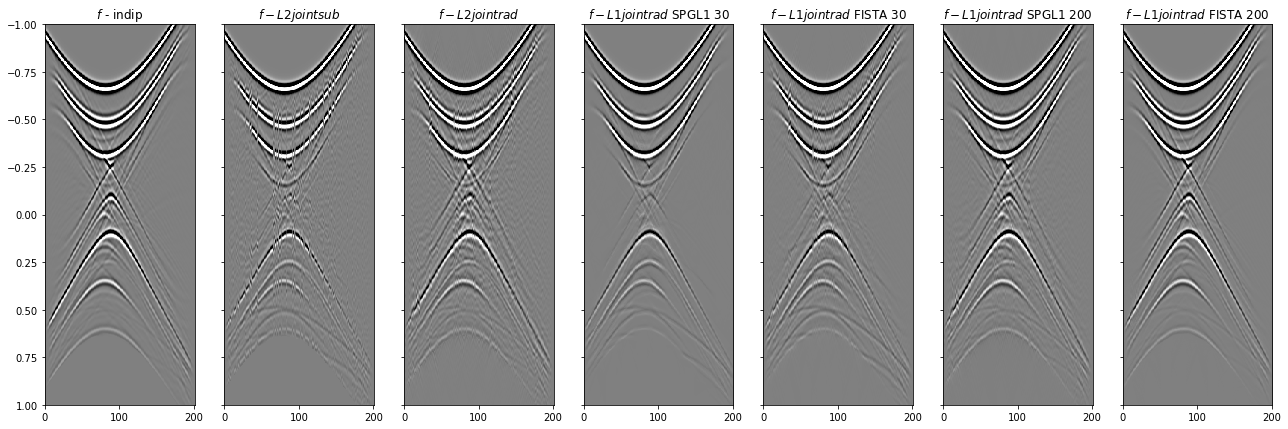

In [57]:
fig, axs = plt.subplots(1, 7, sharey=True, figsize=(22, 7))
axs[0].imshow(f1_1_minus_l2indip.T + f1_1_plus_l2indip.T, cmap='gray',
              vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[0].set_title(r'$f$ - indip')
axs[0].axis('tight')
axs[1].imshow(f1_1_minus_l2sub.T + f1_1_plus_l2sub.T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[1].set_title(r'$f - L2jointsub$')
axs[1].axis('tight')
axs[2].imshow(f1_1_minus_l2radon.T + f1_1_plus_l2radon.T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[2].set_title(r'$f - L2jointrad$')
axs[2].axis('tight')
axs[3].imshow(f1_1_minus_l1radon_spgl1_early.T + f1_1_plus_l1radon_spgl1_early.T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[3].set_title(r'$f - L1jointrad$ SPGL1 30')
axs[3].axis('tight')
axs[5].imshow(f1_1_minus_l1radon_spgl1.T + f1_1_plus_l1radon_spgl1.T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[5].set_title(r'$f - L1jointrad$ SPGL1 200')
axs[5].axis('tight')
axs[4].imshow(f1_1_minus_l1radon_early.T + f1_1_plus_l1radon_early.T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[4].set_title(r'$f - L1jointrad$ FISTA 30')
axs[4].axis('tight')
axs[6].imshow(f1_1_minus_l1radon.T + f1_1_plus_l1radon.T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[6].set_title(r'$f - L1jointrad$ FISTA 200')
axs[6].axis('tight')
axs[6].set_ylim(1, -1);

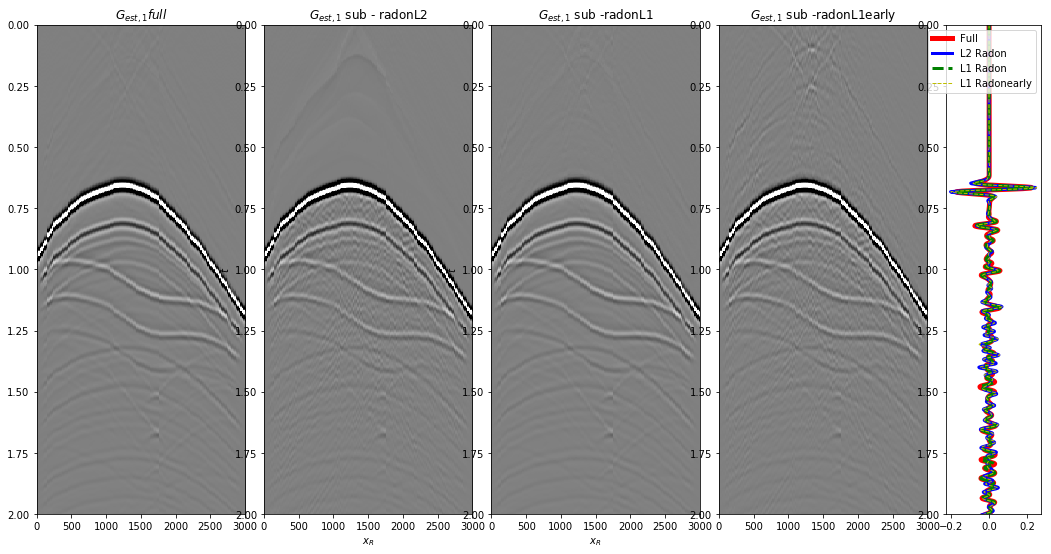

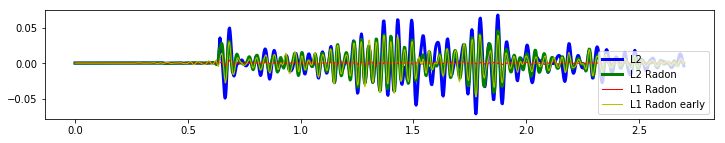

In [54]:
fig = plt.figure(figsize=(18,9))
ax1 = plt.subplot2grid((1, 9), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 9), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 9), (0, 4), colspan=2)
ax4 = plt.subplot2grid((1, 9), (0, 6), colspan=2)
ax5 = plt.subplot2grid((1, 9), (0, 8))

ax1.imshow(g_1_tot_l2[iava1].T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax1.set_title(r'$G_{est,1} full $'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(2, 0)
ax2.imshow(g_1_tot_l2radon.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax2.set_title(r'$G_{est,1}$ sub - radonL2'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(2, 0)
ax3.imshow(g_1_tot_l1radon.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax3.set_title(r'$G_{est,1}$ sub -radonL1'), ax3.set_xlabel(r'$x_R$'), ax3.set_ylabel(r'$t$')
ax3.axis('tight')
ax3.set_ylim(2, 0)
ax4.imshow(g_1_tot_l1radon_early.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax4.set_title(r'$G_{est,1}$ sub -radonL1early'), ax3.set_xlabel(r'$x_R$'), ax3.set_ylabel(r'$t$')
ax4.axis('tight')
ax4.set_ylim(2, 0)
ax5.plot(t**3*g_1_tot_l2[iava1][nr//4, nt-1:]/g_1_tot_l2.max(), t, 'r', lw=5, label='Full')
ax5.plot(t**3*g_1_tot_l2radon[nr//4, nt-1:]/g_1_tot_l2.max(), t, 'b', lw=3, label='L2 Radon')
ax5.plot(t**3*g_1_tot_l1radon[nr//4, nt-1:]/g_1_tot_l2.max(), t, '--g', lw=3, label='L1 Radon')
ax5.plot(t**3*g_1_tot_l1radon_early[nr//4, nt-1:]/g_1_tot_l2.max(), t, '--y', lw=1, label='L1 Radonearly')
ax5.set_ylim(2, 0)
ax5.legend()

plt.figure(figsize=(12, 2))
plt.plot(t, t**3*g_1_tot_l2[iava1][nr//4, nt-1:]/g_1_tot_l2.max() - t**3*g_1_tot_l2sub[nr//4, nt-1:]/g_1_tot_l2.max(), 
         'b', lw=3, label='L2')
plt.plot(t, t**3*g_1_tot_l2[iava1][nr//4, nt-1:]/g_1_tot_l2.max() - t**3*g_1_tot_l2radon[nr//4, nt-1:]/g_1_tot_l2.max(), 
         'g', lw=3, label='L2 Radon')
plt.plot(t, t**3*g_1_tot_l2[iava1][nr//4, nt-1:]/g_1_tot_l2.max() - t**3*g_1_tot_l1radon[nr//4, nt-1:]/g_1_tot_l2.max(), 
         'r', lw=1, label='L1 Radon')
plt.plot(t, t**3*g_1_tot_l2[iava1][nr//4, nt-1:]/g_1_tot_l2.max() - t**3*g_1_tot_l1radon_early[nr//4, nt-1:]/g_1_tot_l2.max(), 
         'y', lw=1, label='L1 Radon early')
plt.legend();

In [58]:
from scipy.io import savemat

savemat('MckJoint_Radon_Fista.mat', {'t':t, 'nr':nr,
                                     'f1_l2j':f1_1_minus_l2indip.T + f1_1_plus_l2sub.T,
                                    'f1_l2radon':f1_1_minus_l2radon.T + f1_1_plus_l2radon.T,
                                    'f1_l2radon':f1_1_minus_l2radon.T + f1_1_plus_l2radon.T,
                                    'f1_l1radon_spgl1_early':f1_1_minus_l1radon_spgl1_early.T + f1_1_minus_l1radon_spgl1_early.T,
                                    'f1_l1radon_fista_early':f1_1_minus_l1radon_early.T + f1_1_plus_l1radon_early.T,
                                   'f1_l1radon_spgl1':f1_1_minus_l1radon_spgl1.T + f1_1_minus_l1radon_spgl1.T,
                                   'f1_l1radon_fista':f1_1_minus_l1radon.T + f1_1_plus_l1radon.T,
                                   'mse_l2':mse_l2,
                                   'n_iters_l2sub':n_iters_l2sub, 'mse_l2sub':mse_l2sub,
                                   'n_iters_l2radon':n_iters_l2radon, 'mse_l2radon':mse_l2radon,
                                   'n_iters_l1radon':np.arange(n_iter), 'mse_l1radon':mse_l1radon,
                                   'n_iters_l1radon_spgl1':n_iters_l1radon_spgl1, 'mse_l1radon_spgl1':mse_l1radon_spgl1})